# Información del grupo

### **GRUPO 01: Los defensores de Pearson**

## Integrantes:



* [111019] Fernández Ignacio - iafernandez@fi.uba.ar
* ~~[106675] Gino Oggero - goggero@fi.uba.ar~~
* [109458] Molina Taiel Alexis - tamolina@fi.uba.ar
* [104115] Sebastián Vera Benítez - svera@fi.uba.ar

> Gino Oggero dejó la cursada.


# 0. Preparación de la notebook

## Dependencias

In [279]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import geopandas as gpd

Incluir los archivos `barrios.geojson` y `properati_argentina_2021`

## Constantes

In [280]:
from constants import *

## Funciones

### Grafico de barras

In [281]:
def plotear_grafico(df_to_graph, title, xlabel, ylabel):

  plt.figure(figsize=(10, 6))
  df_to_graph.plot(kind="bar")
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(rotation=90)
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.tight_layout()
  plt.show()

In [282]:
def grafico_correlacion_por_categoría(colX, colY, colCualit):
    categorias = df[colCualit].unique()
    correlaciones = []

    for categoria in categorias:
        subset = df[df[colCualit] == categoria]
        correlacion = subset[colX].corr(subset[colY])
        correlaciones.append(correlacion)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categorias, y=correlaciones)
    plt.title(f"Correlación entre {colX} y {colY} por {colCualit}")
    plt.xlabel(colCualit)
    plt.ylabel("Correlación")
    plt.xticks(rotation=45)
    plt.show()

In [283]:
def grafico_porcentaje_nulls_por_fila():
  promedio_no_nulos = df.notnull().sum(axis=1).mean()
  promedio_nulos = df.isnull().sum(axis=1).mean()

  total = promedio_no_nulos + promedio_nulos

  porcentaje_no_nulos = promedio_no_nulos / total * 100
  porcentaje_nulos = promedio_nulos / total * 100

  etiquetas = ["Promedio por fila"]
  valores_no_nulos = [porcentaje_no_nulos]
  valores_nulos = [porcentaje_nulos]

  plt.figure(figsize=(8, 6))

  plt.bar(etiquetas, valores_no_nulos, color=CELESTE, label="Valores no nulos")
  plt.bar(etiquetas, valores_nulos, bottom=valores_no_nulos, color=CORAL, label="Valores nulos")

  plt.title("Porcentaje promedio de valores no nulos y nulos por fila")
  # plt.xlabel("Promedio por fila")
  plt.ylabel("Porcentaje (%)")
  plt.legend()

  plt.show()

In [284]:
def graficar_correlaciones_superficie_por_tipo_de_propiedad():
  correlacion_por_place_l3 = df_departamentos.groupby("place_l3").apply(lambda x: x["property_surface_covered"].corr(x["property_surface_total"]))

  plt.figure(figsize=(12, 6))
  sns.barplot(x=correlacion_por_place_l3.index, y=correlacion_por_place_l3.values, color=AZUL)
  plt.title("Correlación entre superficie cubierta y superficie total por place_l3 (Departamentos)")
  plt.xlabel("place_l3")
  plt.ylabel("Correlación")
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

In [285]:
def graficar_correlaciones_superficie_por_place_l3():
  muestras_por_place_l3 = df_departamentos.groupby("place_l3").size()

  plt.figure(figsize=(12, 6))
  sns.barplot(x=muestras_por_place_l3.index, y=muestras_por_place_l3.values, color=VERDE)
  plt.title("Cantidad de muestras por place_l3 (Departamentos)")
  plt.xlabel("place_l3")
  plt.ylabel("Cantidad de muestras")
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

### Torta

In [286]:
def grafico_pie_correlacion_por_tipo_y_barrio():

  correlacion_por_tipo = df.groupby("property_type").apply(lambda x: x["property_surface_total"].corr(x["property_surface_covered"]))

  correlacion_por_place_l3 = df_departamentos.groupby("place_l3").apply(lambda x: x["property_surface_covered"].corr(x["property_surface_total"]))

  correlacion_por_place_l3_ordenados = correlacion_por_place_l3.sort_values(ascending=False)

  total_values = len(correlacion_por_place_l3)

  porcentaje_nan = (correlacion_por_place_l3.isnull().sum() / total_values) * 100
  porcentaje_08 = (np.sum(correlacion_por_place_l3[correlacion_por_place_l3 >= 0.8]) / total_values) * 100
  porcentaje_lt_09 = (np.sum(correlacion_por_place_l3[(correlacion_por_place_l3 >= 0) & (correlacion_por_place_l3 < 0.8)]) / total_values) * 100

  labels = ["NaN", ">= 0.8", "< 0.8"]
  porcentajes = [porcentaje_nan, porcentaje_08, porcentaje_lt_09]

  plt.pie(porcentajes, labels=labels, autopct="%1.1f%%", colors=[AZUL, VERDE, NARANJA])
  plt.title("Porcentaje de valores en la correlación entre superficie cubierta y total para departamentos")
  plt.show()

### Distribuciones

In [287]:
def mostrar_distros_cuantitativas(columna):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=columna)
    plt.title(f"Cantidad de muestras por {columna}")
    plt.xlabel(columna)
    plt.ylabel("Cantidad de muestras")
    plt.xticks(rotation=45)
    plt.show()

In [288]:
def mostrar_distros_cuantitativas_continuas(columna):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=columna, bins=40)
    plt.title(f"Cantidad de muestras por {columna}")
    plt.xlabel(columna)
    plt.ylabel("Cantidad de muestras")
    plt.xticks(rotation=45)
    plt.show()

In [289]:
def mostrar_distros_cualitativas(columna):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    axes[0].hist(_df[columna], bins=30, color=AZUL, alpha=0.7)
    axes[0].set_xlabel("Valores")
    axes[0].set_ylabel("Frecuencia")
    axes[0].set_title("Histograma")

    sns.boxplot(data=_df[columna], ax=axes[1], color=VERDE)
    axes[1].set_ylabel("Valores")
    axes[1].set_title("Boxplot")

    fig.suptitle(f"Distribución de {columna}")
    plt.tight_layout()
    plt.show()

### Dispersión

In [290]:
def mostrar_dispersion(colX, colY):
  plt.scatter(df[colX], df[colY])
  plt.xlabel(colX)
  plt.ylabel(colY)
  plt.title(f"Dispersión entre {colX} y {colY}")
  plt.show()

In [291]:
def mostrar_dispersion_3d(colX,colY,colZ):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    _colX = df[colX]
    _colY = df[colY]
    _colZ = df[colZ]

    scatter = ax.scatter(_colX, _colY, _colZ, c=_colZ, cmap='viridis', marker="o")
    fig.colorbar(scatter, ax=ax, label=colZ)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.set_zlabel(colZ)

    ax.set_title(f"Dispersión 3D de {colX}, {colY} y {colZ}")

    plt.show()

In [292]:
def grafico_dispersión_aproximación_lineal(colX, colY):
    x = df[colX]
    y = df[colY]

    coeficientes = np.polyfit(x, y, 1)
    polinomio = np.poly1d(coeficientes)

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color=AZUL, label="Datos")
    plt.plot(x, polinomio(x), color=ROJO, label="Aproximación lineal")
    plt.title(f"Aproximación lineal de {colX} y {colY}")
    plt.xlabel(colX)
    plt.ylabel(colY)
    plt.legend()
    plt.grid(True)
    plt.show()

### Heatmap

In [293]:
def graficar_heatmap(colsArr):
  plt.figure(figsize=(6, 4))
  ax = sns.heatmap(df[colsArr].corr(), annot=True)
  ax.set_title("Índice de correlación")
  plt.show()

## Lectura de datos

In [294]:
df_raw = pd.read_csv(path_df)

# 1. Análisis exploratorio y preprocesamiento de datos

## Preparación del dataframe

### Vistazo inicial en crudo

In [295]:
df_raw.shape

(460154, 20)

In [296]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [297]:
df_raw.head(3)

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   

   property_surface_covered  property_price property_currency  property_title  
0                     206.0             NaN               NaN  Casa - Capital  
1                     193.0        390000.0               USD   Casa - Malvín  
2                      45.0         47000.0               USD  Casa - Uruguay

### Filtrado

Vamos a analizar una parte de la información leida. Antes de realizar el filtrado indicado analizamos el contenido de las columnas involucradas en la selección de datos para prevenir errores filtrando.

Por ejemplo, si queremos filtrar publicaciones en dolares, cabría la posibilidad de que la columna `property_currency` tenga distintas formas de expresar el mismo valor. `USD`, `usd`, `Dolar estadounidense`, etc.

#### Visualización de valores de las columnas a filtrar

In [298]:
df_raw["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [299]:
df_raw["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [300]:
df_raw["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [301]:
df_raw["place_l2"].value_counts()

place_l2
Capital Federal                 157563
Bs.As. G.B.A. Zona Norte         89693
Santa Fe                         47861
Bs.As. G.B.A. Zona Sur           47754
Bs.As. G.B.A. Zona Oeste         28352
Córdoba                          22528
Buenos Aires Costa Atlántica     12457
Neuquén                           8788
Montevideo                        7494
Buenos Aires Interior             6274
Maldonado                         5540
Mendoza                           5395
Río Negro                         5280
Tucumán                           3571
Colonia                           2535
Salta                             1537
Entre Ríos                        1216
San Juan                           997
La Pampa                           783
Canelones                          744
Chubut                             701
San Luis                           677
Misiones                           529
Florida                            411
Jujuy                              406
Corrientes      

Viendo que los criterios de filtro no tienen variantes, realizamos el filtrado.
Como observación a tener en cuenta, el tipo de propiedades "Otro" podría llegar a tener información útil y con esta podríamos ampliar el dataframe obtenido.
Un ejemplo podría ser una "Casa de veraneo" que sea clasificada como  `Otro` en lugar de como `Casa`.

#### Filtrado

In [302]:
tipos_propiedades = ["Departamento", "Casa", "PH"]

df_raw = df_raw[(df_raw["property_currency"] == "USD") & (df_raw["operation"] == "Venta") & (df_raw["property_type"].isin(tipos_propiedades)) &
        (df_raw["place_l2"] == "Capital Federal")]


### División en dataframes de entrenamiento y prueba

Separamos el dataframe en prueba y entrenamiento

In [303]:
# Variando la seed se modifican los df de prueba y de entrenamiento. La idea es que quede fija.
seed = 123

_df, df_test = train_test_split(df_raw, test_size=0.2, random_state=seed)

df = _df # creo esta copia para luego poder comparar las distros antes y despues de imputar datos.

print(df_raw.shape)
print(_df.shape)
print(df_test.shape)

(94249, 20)
(75399, 20)
(18850, 20)


## A. Exploración inicial

### Variables cuantitativas

#### Discretas

Estas columnas son discretas ya que representan fechas pero no horas.

In [304]:
print(df["start_date"].min())
print(df["start_date"].max())

2021-01-01
2021-12-31


In [305]:
print(df["end_date"].min())
print(df["end_date"].max())

2021-01-02
9999-12-31


In [306]:
print(df["created_on"].min())
print(df["created_on"].max())

2021-01-01
2021-12-31


In [307]:
df["property_rooms"].mean(), df["property_rooms"].median(), df["property_rooms"].mode()[0]

(2.8221715512038092, 3.0, 3.0)

In [308]:
df["property_bedrooms"].mean(), df["property_bedrooms"].median(), df["property_bedrooms"].mode()[0]

(2.013289734205316, 2.0, 1.0)

#### Continuas

In [309]:
df["latitud"].mean(), df["latitud"].median(), df["latitud"].mode()[0]

(-34.59126352648724, -34.59573237315, -34.5412501)

In [310]:
df["longitud"].mean(), df["longitud"].median(), df["longitud"].mode()[0]

(-58.449369334704855, -58.4389166, -58.4729664)

In [311]:
df["property_surface_covered"].mean(), df["property_surface_covered"].median(), df["property_surface_covered"].mode()[0]

(89.04041959387932, 58.0, 40.0)

In [312]:
df["property_surface_total"].mean(), df["property_surface_total"].median(), df["property_surface_total"].mode()[0]

(109.0961073450276, 65.0, 50.0)

In [313]:
df["property_price"].mean(), df["property_price"].median(), df["property_price"].mode()[0]

(226092.01221501612, 144000.0, 110000.0)

### Variables Cualitativas


#### Place_l

Los distintos **place_l** son variables cualitativas. Buscamos los distintos valores que adoptan.


In [314]:
df["place_l2"].value_counts(dropna=False)

place_l2
Capital Federal    75399
Name: count, dtype: int64

In [315]:
df["place_l3"].value_counts(dropna=False)

place_l3
Palermo                 11448
Belgrano                 7173
Caballito                5688
Recoleta                 5031
Villa Urquiza            3794
Almagro                  3291
Nuñez                    2839
Villa Crespo             2563
Flores                   2460
Barrio Norte             2418
Balvanera                2071
Colegiales               1571
Villa Devoto             1533
Saavedra                 1447
Villa del Parque         1446
Puerto Madero            1207
San Telmo                1118
San Nicolás              1053
San Cristobal            1027
Barracas                 1011
Retiro                    984
Boedo                     972
Floresta                  950
Monserrat                 893
Parque Chacabuco          859
Villa Pueyrredón          792
Coghlan                   771
Villa Luro                574
Mataderos                 572
Chacarita                 550
Liniers                   536
Villa Ortuzar             512
Parque Patricios          494
V

In [316]:
df["place_l4"].value_counts(dropna=False)

place_l4
NaN                  72496
Palermo Hollywood     1245
Palermo Chico          874
Palermo Soho           648
Palermo Viejo          136
Name: count, dtype: int64

In [317]:
df["place_l5"].value_counts(dropna=False)

place_l5
NaN    75399
Name: count, dtype: int64

In [318]:
df["place_l6"].value_counts(dropna=False)

place_l6
NaN    75399
Name: count, dtype: int64

#### Otras cualitatias

In [319]:
df["operation"].value_counts(dropna=False)

operation
Venta    75399
Name: count, dtype: int64

In [320]:
df["property_type"].value_counts(dropna=False)

property_type
Departamento    64698
PH               7392
Casa             3309
Name: count, dtype: int64

In [321]:
df["property_currency"].value_counts(dropna=False)

property_currency
USD    75399
Name: count, dtype: int64

In [322]:
df["property_title"].value_counts(dropna=False)

property_title
Departamento - Palermo                                                                          1182
Departamento - Recoleta                                                                         1064
Departamento - Belgrano                                                                          893
Departamento - Caballito                                                                         753
Departamento - Almagro                                                                           541
                                                                                                ... 
Excelente departamento 4 amb. C/ Dep y cochera!!!!                                                 1
4 AMBIENTES COCINA INDEPENDIENTE CON BALCÓN AL FRENTE                                              1
VENTA depto 5 amb en esquina luminosa c/ terraza y quincho priv - Serrano 700,  Palermo Soho       1
Venta departamento 3 ambientes con baulera                                  

### Variables irrelevantes

En el apartado `1)A)Variables cualitativas` podemos notar que hay columnas cuyo valor se repite en todos los registros. De esta forma estas columnas no aportan información y pueden eliminarse.

In [323]:
df = df.drop("property_currency", axis=1)
df = df.drop("operation", axis=1)

En la misma sección tambien encontramos una alta presencia de `Null` en `place_l4`, `place_l5` y `place_l6`, por lo que tambien las eliminamos.

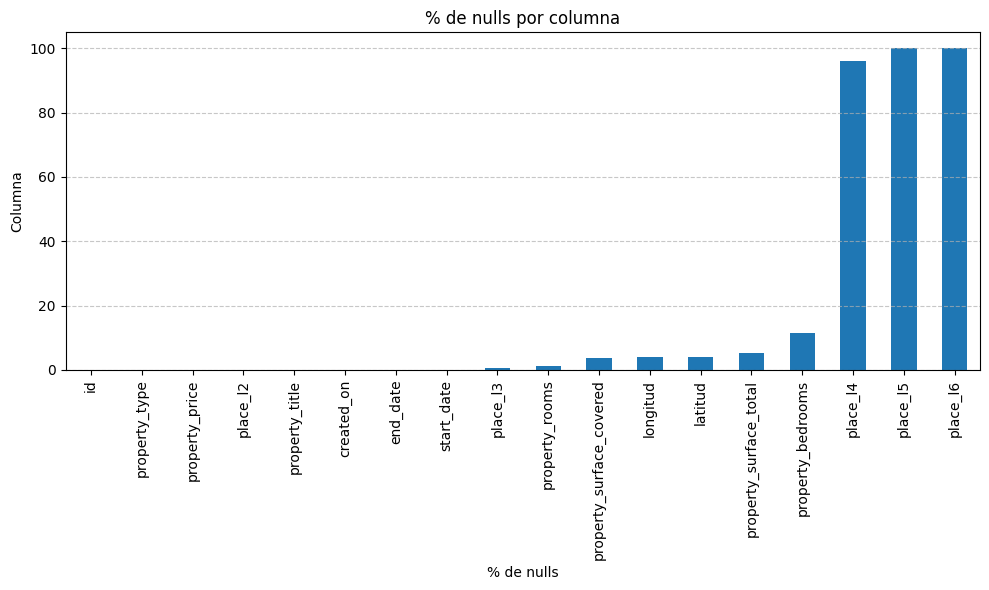

In [324]:
df_to_graph = ((df.isnull().sum() / len(df)) * 100).sort_values()

plotear_grafico(df_to_graph, "% de nulls por columna", "% de nulls", "Columna")

In [325]:
df = df.drop("place_l4", axis=1)
df = df.drop("place_l5", axis=1)
df = df.drop("place_l6", axis=1)

Por otro lado, las fechas no nos aportan una información relevante.
El ID es eliminado ya que no vamos a analizar individualmente cada propiedad, por lo que a nivel conjunto es un dato que no aporta.

In [326]:
df = df.drop("id", axis=1)
df = df.drop("start_date", axis=1)
df = df.drop("end_date", axis=1)
df = df.drop("created_on", axis=1)

Finalmente nos queda el siguiente dataframe

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75399 entries, 129124 to 74957
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   72386 non-null  float64
 1   longitud                  72386 non-null  float64
 2   place_l2                  75399 non-null  object 
 3   place_l3                  75077 non-null  object 
 4   property_type             75399 non-null  object 
 5   property_rooms            74555 non-null  float64
 6   property_bedrooms         66668 non-null  float64
 7   property_surface_total    71545 non-null  float64
 8   property_surface_covered  72737 non-null  float64
 9   property_price            75399 non-null  float64
 10  property_title            75399 non-null  object 
dtypes: float64(7), object(4)
memory usage: 6.9+ MB


## B. Visualización de los datos

### Distribuciones


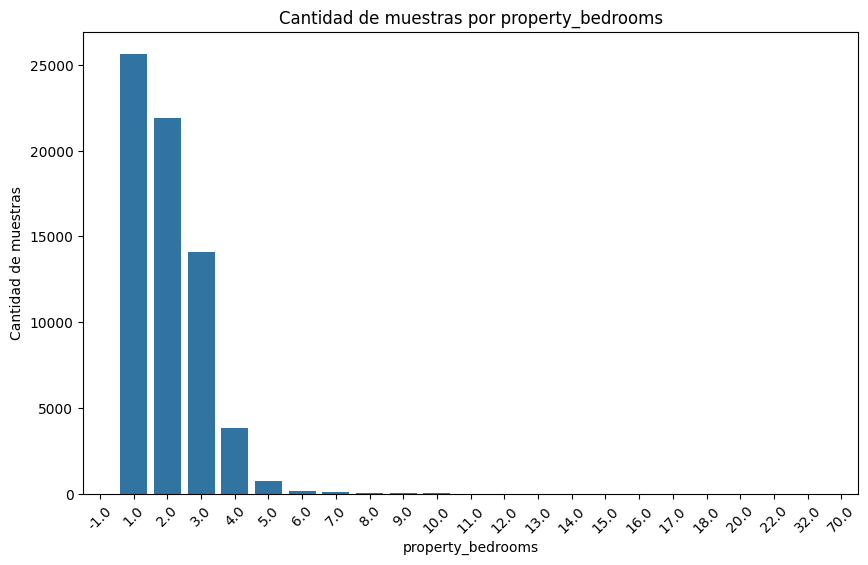

In [328]:
mostrar_distros_cuantitativas("property_bedrooms")

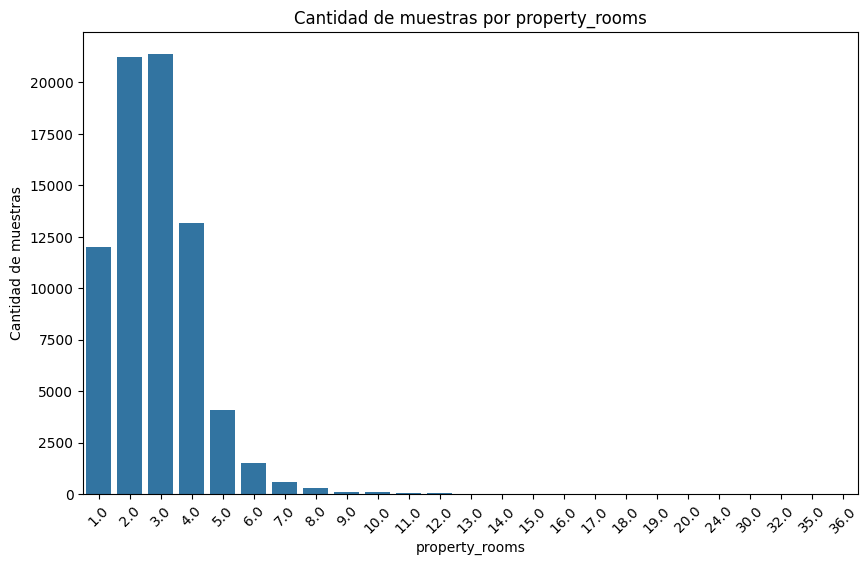

In [329]:
mostrar_distros_cuantitativas("property_rooms")

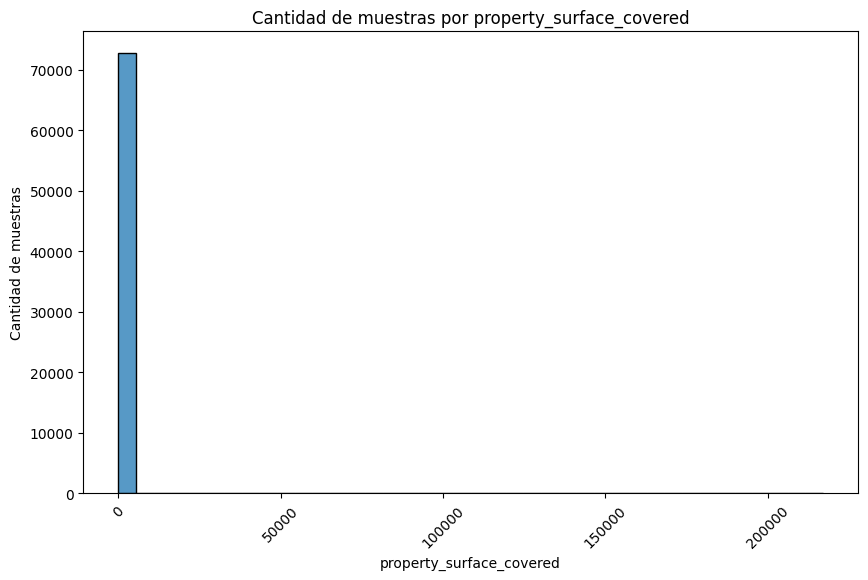

In [330]:
mostrar_distros_cuantitativas_continuas("property_surface_covered")

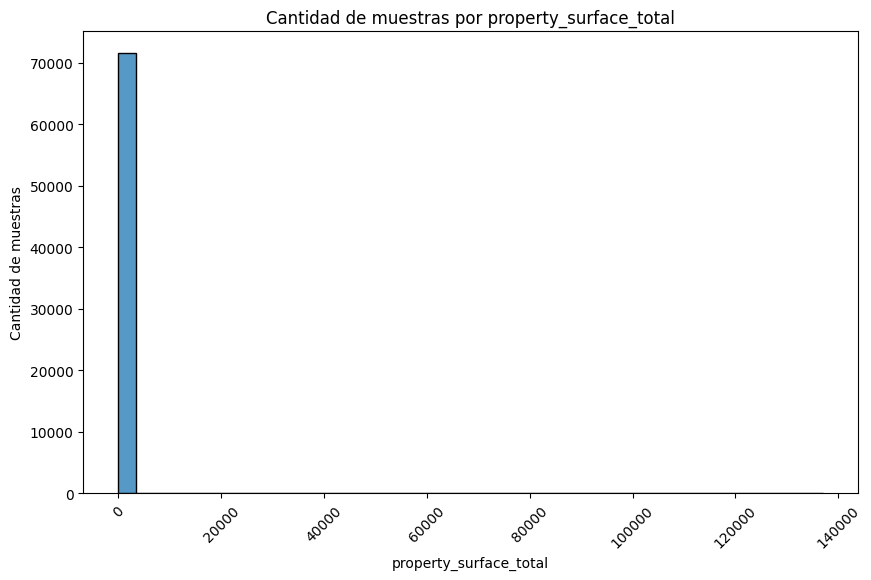

In [331]:
mostrar_distros_cuantitativas_continuas("property_surface_total")

En los graficos de distribuciones cuantitativas continuas apreciamos una gran acumulación. Para poder ver a detalle será necesario revisar los datos que agrandan la escala y generan esos cúmulos.

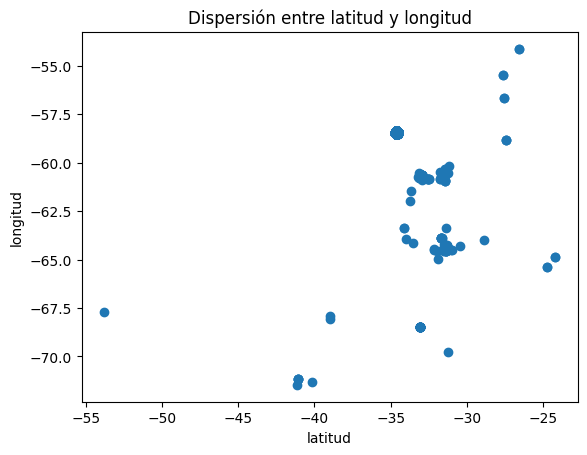

In [332]:
mostrar_dispersion("latitud","longitud")

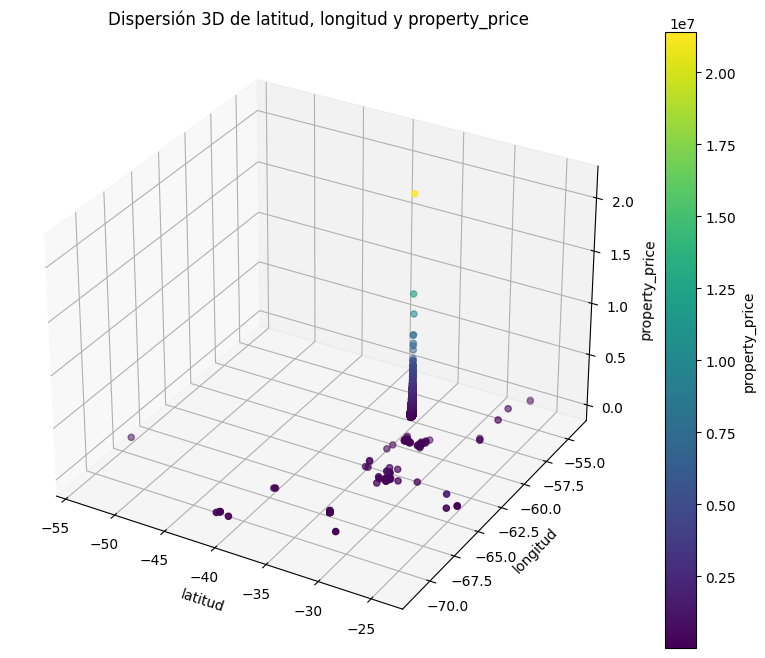

In [333]:
mostrar_dispersion_3d("latitud","longitud","property_price")

Vemos que hay una acumulación de muestras sobre un espacio relativamente reducido. El gráfico puede llegar a brindar informacion muy relevante.

Una posible sanitización de esta información puede darse de la siguiente manera:

Evaluar basandose en place_l3 las coordenadas de cada fila. Si estas corresponden al place_l3, entonces mantener su valor. Sino, modificar las coordenadas para que se ubiquen en el centro real de dicho place_l3.
Pueden utilizarse los mapas provistos por el gobierno de la ciudad para esta tarea.

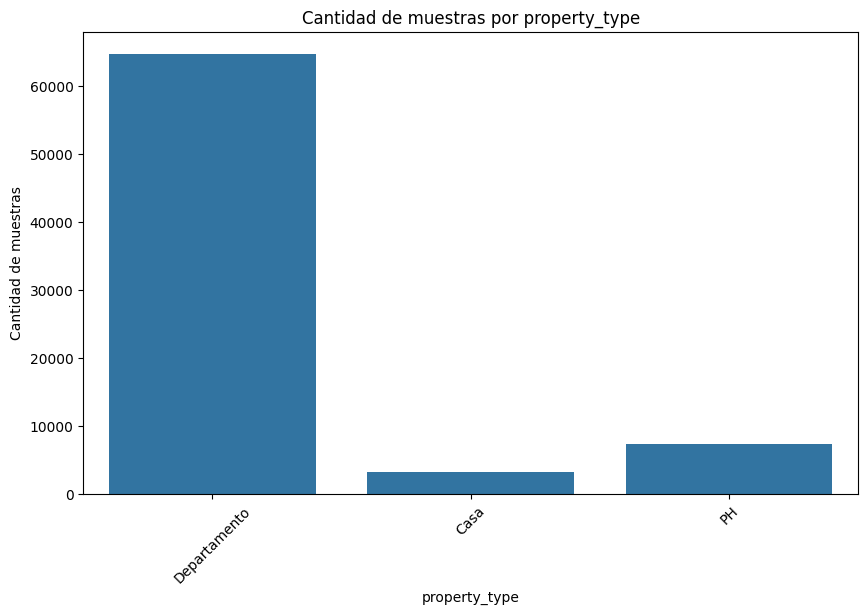

In [334]:
mostrar_distros_cuantitativas("property_type")

### Correlaciones

#### Heatmap

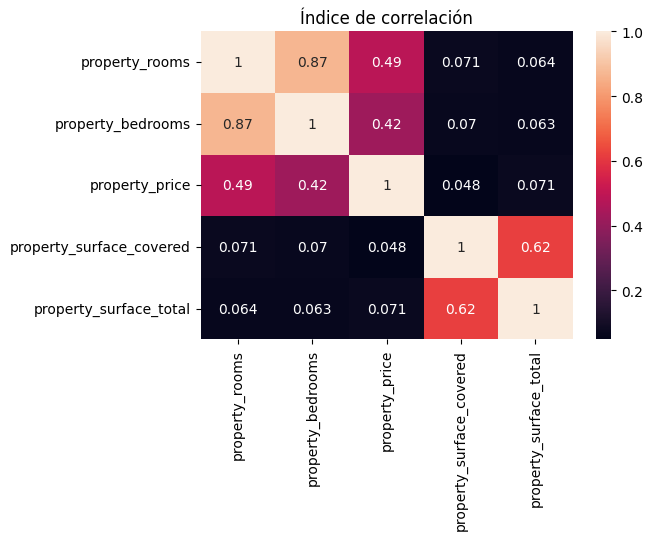

In [335]:
graficar_heatmap(["property_rooms", "property_bedrooms", "property_price", "property_surface_covered", "property_surface_total"])

La relacion entre superficie total y cubierta no es para nada la esperable para una grán ciudad como lo es Capital Federal con muchos edificios y pocos patios.
La relación entre cantidad de habitaciones y ambientes da la sensación de que debería ser aún más alta.
Sería interesante analizar algunas de estas correlaciones por tipo de propiedad, como así tambien ver como se comporta analizandolas por barrios.

#### Relación entre cantidad de habitaciones y de ambientes

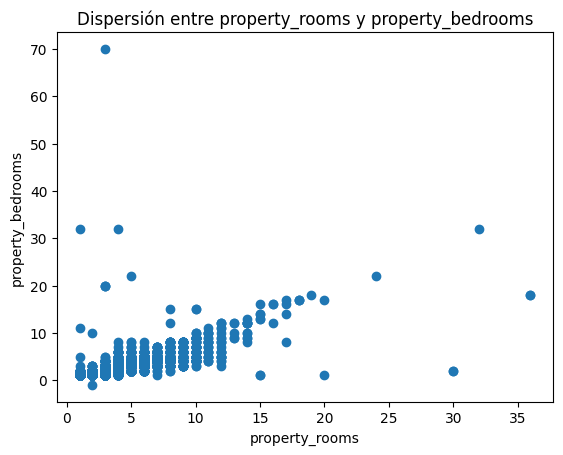

In [336]:
mostrar_dispersion("property_rooms","property_bedrooms")

Los puntos aislados levantan mucha sospecha. Además, considerando que toda habitación es un ambiente, es imposible que haya más de las primeras que de las segundas, por lo que se pueden ver unos cuantos errores.

#### Relacion entre superficies

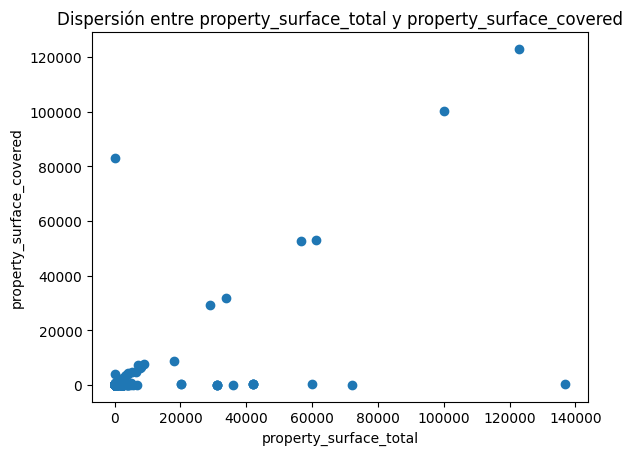

In [337]:
mostrar_dispersion("property_surface_total","property_surface_covered")

Similar al caso anterior. La superficie cubierta es parte de la total. Si bien la tendencia tiene sentido, los valores que se encuentran por encima de la linea presentan un claro error.

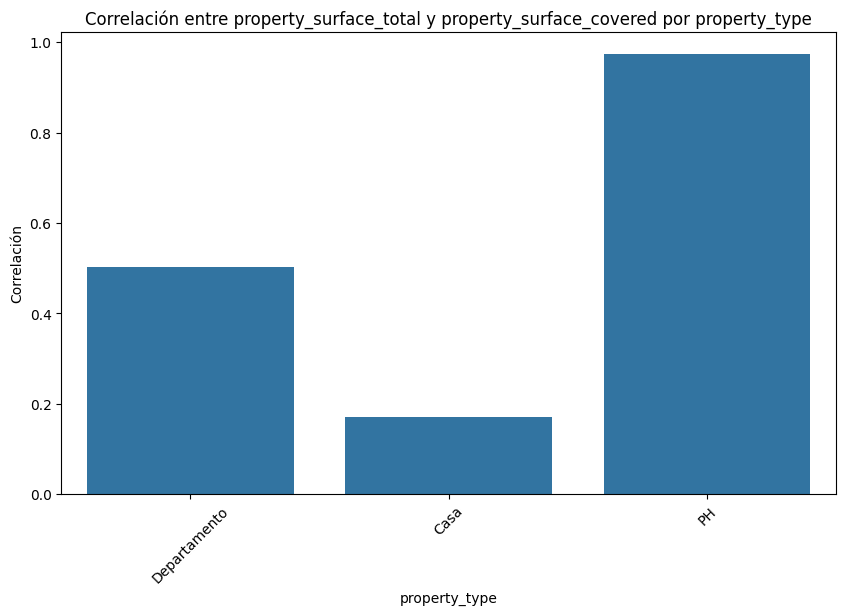

In [338]:
grafico_correlacion_por_categoría("property_surface_total","property_surface_covered","property_type")

Estas correlaciones se ven extrañas para ser capital federal. Uno no esperaría que las casas tengan poca relación entre los tipos de superficie, y mucho menos en los departamentos.

In [339]:
df_departamentos = df[df["property_type"] == "Departamento"]

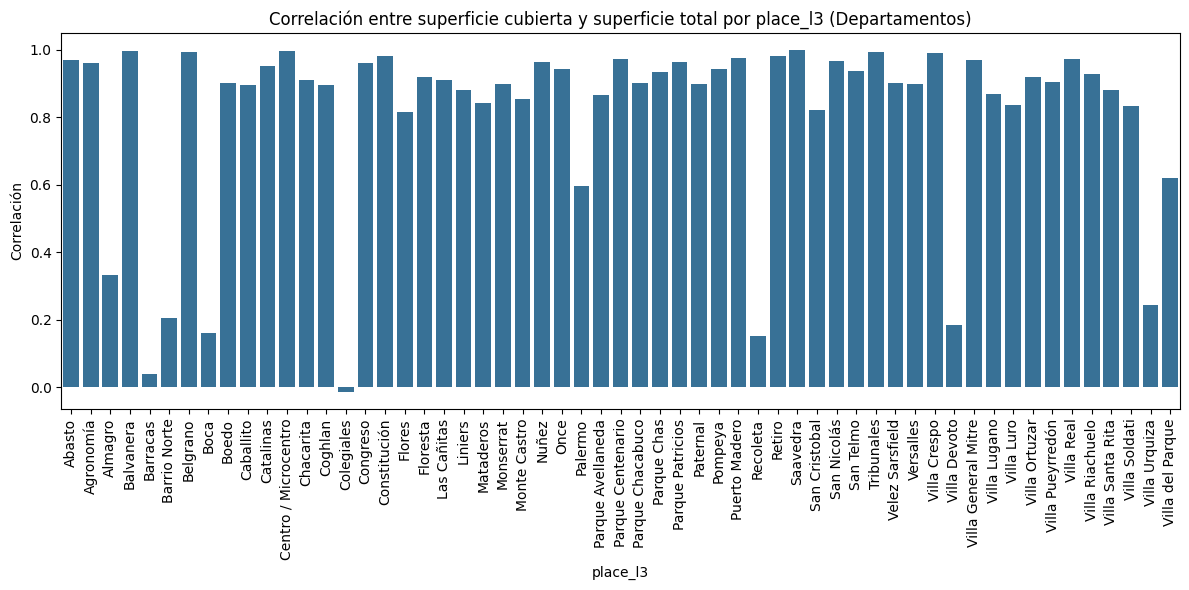

In [340]:
graficar_correlaciones_superficie_por_tipo_de_propiedad()

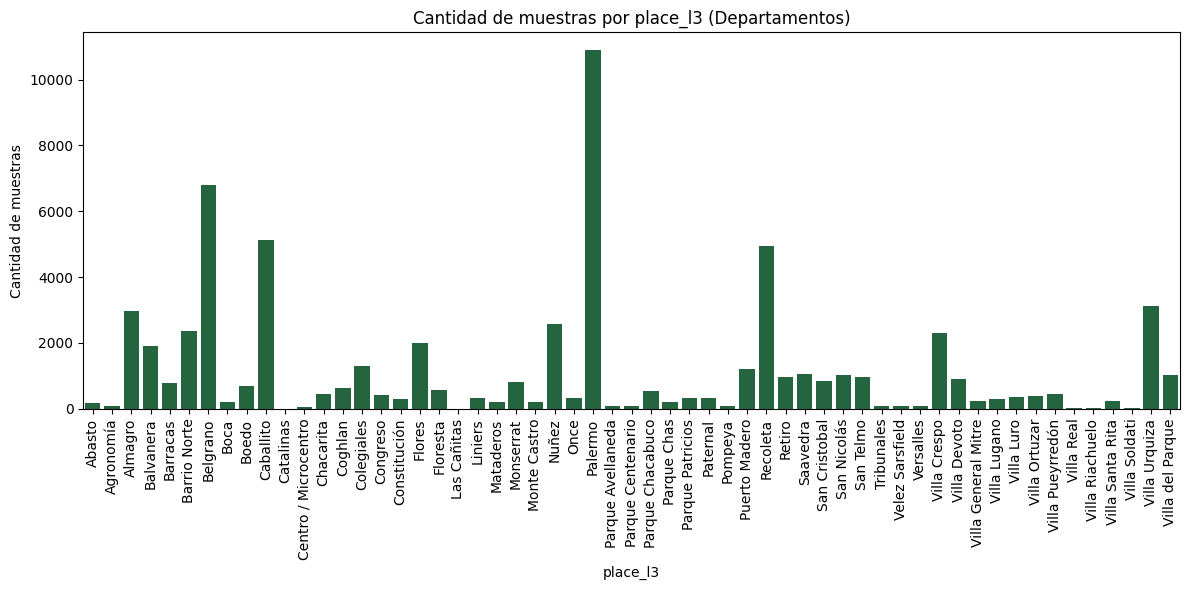

In [341]:
graficar_correlaciones_superficie_por_place_l3()

## C. Datos faltantes

#### Nulls generales

Luego de haber borrado las columnas con mayor proporción de datos faltantes y analizar tendencias, vamos a evaluar la calidad de la información de la que disponemos hasta el momento.

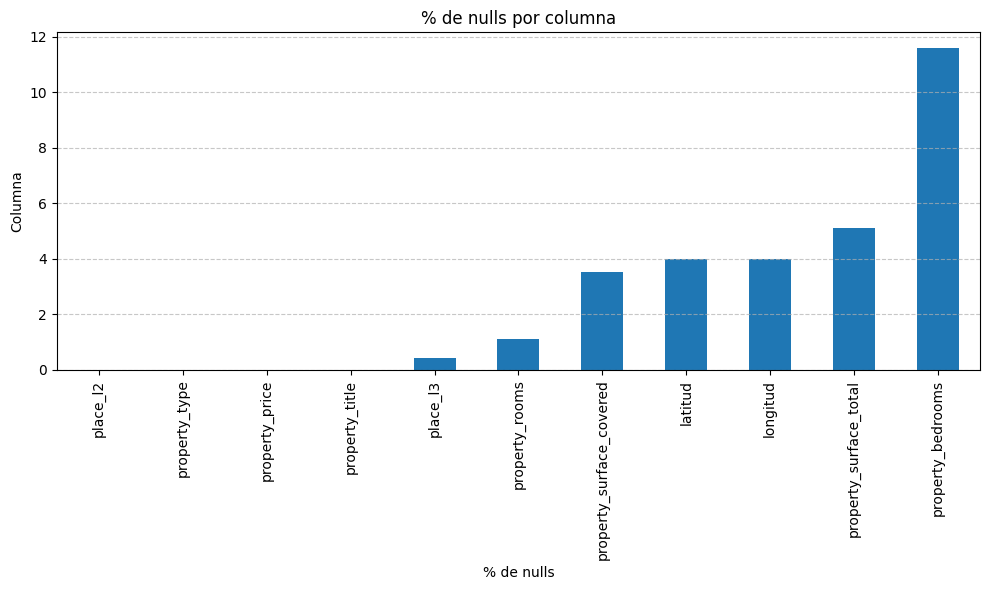

In [342]:
df_to_graph = ((df.isnull().sum() / len(df)) * 100).sort_values()

plotear_grafico(df_to_graph, "% de nulls por columna", "% de nulls", "Columna")

In [343]:
df.isnull().sum()

latitud                     3013
longitud                    3013
place_l2                       0
place_l3                     322
property_type                  0
property_rooms               844
property_bedrooms           8731
property_surface_total      3854
property_surface_covered    2662
property_price                 0
property_title                 0
dtype: int64

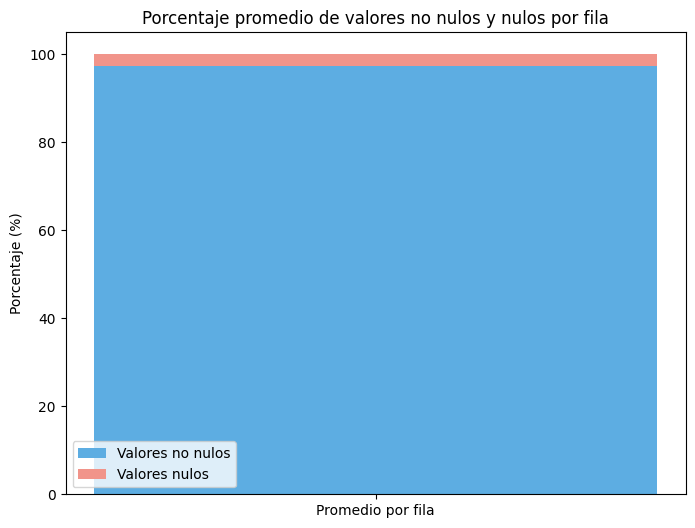

In [344]:
grafico_porcentaje_nulls_por_fila()

#### Tratamiento de nulls

##### Latitud y longitud

En un principio dropeamos las filas que tienen valores nulos (que justo son filas que todas tienen nulos ambas columnas), y veremos más adelante como funciona el modelo. Llegado al caso pondremos el centro de los barrios que indiquen los place_l3 (de no ser nulos).

In [345]:
df.dropna(subset=["latitud", "longitud"], inplace=True)

##### Place_l3

Siendo que representa un porcentaje minúsculo de los datos y el dato es crucial, eliminamos las filas.

Una posible opción a futuro es imputarlo en base a las coordenadas.

In [346]:
df = df.dropna(subset=["place_l3"])

##### Cantidad de habitaciones y de ambientes

Partiendo de la primicia de que toda habitación es un ambiente y no al reves, y que por lo general existe 1 ambiente más que habitaciones (el living), vamos a hacer lo siguiente:

In [347]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df = df.dropna(subset=["property_bedrooms", "property_rooms"])

#2. Imputar la cantidad de habitaciones como cantidad de ambientes - 1
df["property_bedrooms"].fillna(df["property_rooms"] - 1, inplace=True)

#3. Imputar la cantidad de ambientes como cantidad de habitaciones + 1
df["property_rooms"].fillna(df["property_bedrooms"] + 1, inplace=True)

##### Superficie cubierta y total

Siguiendo una lógica similar a la de las habitaciones y ambientes, el total de superficie esta compuesto por la suma se superficie cubierta y descubierta, imputamos una con el valor de la otra.

Por el momento este es un punto de mejora ya que, por lo visto en los gráficos, la relación entre ambos no es lo suficientemente alta como para imputar de esta forma con un alto indnice de confianza.
Por otro lado, por conocimiento del negocio sabemos que en Capital Federal los espacios abiertos en propiedades son más bien reducidos, por lo que sería esperable que la superficie total sea igual o apenas superior a la superficie cubierta.

In [348]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df = df.dropna(subset=["property_surface_covered", "property_surface_total"])

#2. Imputar la superficie cubierta como superficie total
df["property_surface_covered"].fillna(df["property_surface_total"], inplace=True)

#3. Imputar superficie total como superficie cubierta
df["property_surface_total"].fillna(df["property_surface_covered"], inplace=True)

#### Conclusion parcial
En este punto ya no deberíamos presentar nulls.

In [349]:
df.isnull().sum()

latitud                     0
longitud                    0
place_l2                    0
place_l3                    0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
property_title              0
dtype: int64

Nuestra idea para el proximo checkpoint es intentar salvar estos datos que tienen ambas coordenadas con valor nulo, pero en principio los descartamos.

In [350]:
df = df.dropna()

#### Datos mal ingresados

##### Precio

In [351]:
df[df["property_price"] <= 0].shape

(0, 11)

##### Latitud y longitud

Deberiamos corroborar utilizando datos geográficos de la ciudad, que evidentemente estén bien ubicados, para los place_l2 y place_l3 indicados, pero en principio no nos metemos en ese análisis.

##### Property price

No hay datos de precios mal ingresados. Aún puede haber precios ilógicos, pero no hay negativos ni nulos.

##### Habitaciones y ambientes

En aquellas con mas ambientes que habitaciones se hace la corrección basandose en el título de la publicación.
En aquellas con uno de los valores negativos las elimino directamente ya que representan una ínfima cantidad

In [352]:
df.head(10)

latitud   longitud         place_l2       place_l3 property_type  \
115426 -34.598103 -58.442806  Capital Federal   Villa Crespo  Departamento   
256212 -34.583233 -58.403942  Capital Federal        Palermo  Departamento   
304754 -34.578438 -58.462492  Capital Federal  Villa Ortuzar  Departamento   
259655 -34.597612 -58.419316  Capital Federal        Palermo  Departamento   
172350 -34.612999 -58.424641  Capital Federal        Almagro  Departamento   
200905 -34.578250 -58.458062  Capital Federal     Colegiales  Departamento   
217788 -34.554020 -58.463565  Capital Federal          Nuñez  Departamento   
108023 -34.632133 -58.512233  Capital Federal      Versalles          Casa   
265654 -34.589262 -58.407714  Capital Federal   Barrio Norte  Departamento   
366620 -34.598095 -58.394878  Capital Federal       Recoleta  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
115426             1.0                1.0                    30.0   
256212             4.0                3.0                   200.0   
304754             4.0                3.0                    79.0   
259655             2.0                1.0                    53.0   
172350             3.0                2.0                    73.0   
200905             2.0                1.0                    74.0   
217788             4.0                3.0                    90.0   
108023             5.0                3.0                   247.0   
265654             4.0                3.0                    75.0   
366620             4.0                2.0                   120.0   

        property_surface_covered  property_price  \
115426                      27.0         79000.0   
256212                     200.0        790000.0   
304754                      79.0        178900.0   
259655                      49.0        143900.0   
172350                      63.0        110000.0   
200905                      42.0        135000.0   
217788                      86.0        145000.0   
108023                     150.0        480000.0   
265654                      66.0        199000.0   
366620                     117.0        315000.0   

                                           property_title  
115426  DEPARTAMENTO MONOAMBIENTE - VILLA CRESPO C/COC...  
256212                              1 - Billinghurst 2500  
304754     VENTA DEPARTAMENTO 4 AMBIENTES - VILLA ORTUZAR  
259655  Excelente 2 AMBIENTES   S/ AVENIDA   AL CONTRA...  
172350                             Departamento - Almagro  
200905  Venta 2 ambientes de 74m2 c/patio y parrilla e...  
217788        Departamento 4 ambientes  en venta en Nuñez  
108023  Venta Casa Lote propio· 150m² · 5 Amb · 2 Coch...  
265654                        Departamento - Barrio Norte  
366620           VENTA, 4 AMB, RECOLETA, EXCELENTE ESTADO

In [353]:
df[df["property_bedrooms"] > df["property_rooms"]]

# En un vistazo rápido se ve que el property_title en estos casos coincide con la cantidad de ambientes señalados,
# por lo que el valor a corregir es la cantidad de habitaciones

df.loc[df["property_bedrooms"] > df["property_rooms"], "property_bedrooms"] = df["property_rooms"] - 1


df = df.drop(df[df["property_rooms"] <= 0].index)
df = df.drop(df[df["property_bedrooms"] < 0].index)


##### Superficies

En aquellas con mayor superficie cubierta que total, invierto los valores.

In [354]:
filas_erroneas = df["property_surface_total"] < df["property_surface_covered"]

df.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values


df = df.drop(df[df["property_surface_total"] <= 0].index)
df = df.drop(df[df["property_surface_covered"] < 0].index)


## D. Valores atípicos

### Creacion de nuevas columnas


#### Precio por metro cuadrado

In [355]:
df["total_m2_price"] = df["property_price"] / df["property_surface_total"]
df["covered_m2_price"] = df["property_price"] / df["property_surface_covered"]

### Detectar valores atípicos

#### Superficie total y cubierta

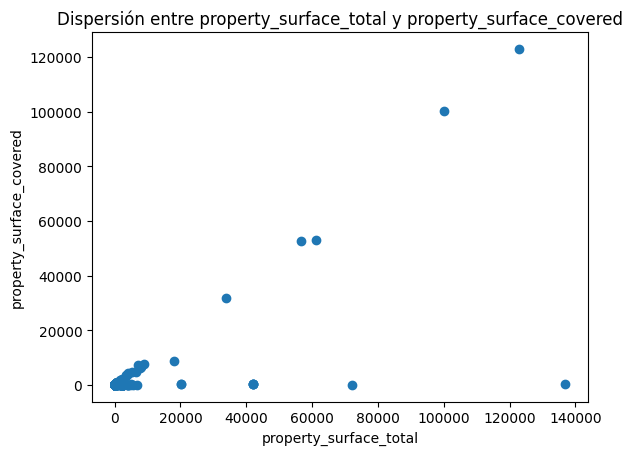

In [356]:
mostrar_dispersion("property_surface_total","property_surface_covered")

Vemos que hay un cúmulo importante de datos en la esquina inferior izquierda del gráfico, y que muy alejados de estos se encuentran otros datos más aislados.
Estos últimos los consideramos outlayers a eliminar.
Siguiendo la lógica del negocio, es impensable encontrar propiedades con tales dimensiones en una ciudad grande como Capital Federal, e incluso fuera de la misma.

A traves de la mediana vamos a calcular un margen generoso (7x) y eliminar a aquellos registros que escapen de este margen.

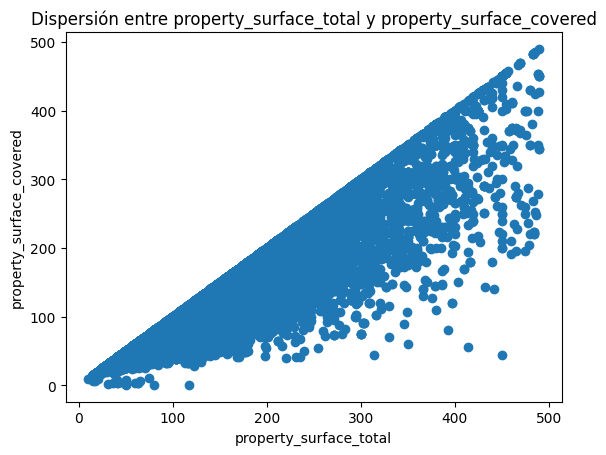

In [357]:
mediana = df["property_surface_total"].median()

limite_superior = mediana * 7

df = df[df["property_surface_total"] <= limite_superior]

mostrar_dispersion("property_surface_total","property_surface_covered")

El gráfico resultante muestra que la imputación realizada previamente satisfactoriamente corrigió los casos donde la superficie cubierta era mayor a la superficie total.
Tambien deja ver un gráfico bastante esperable.

#### Habitaciones y ambientes

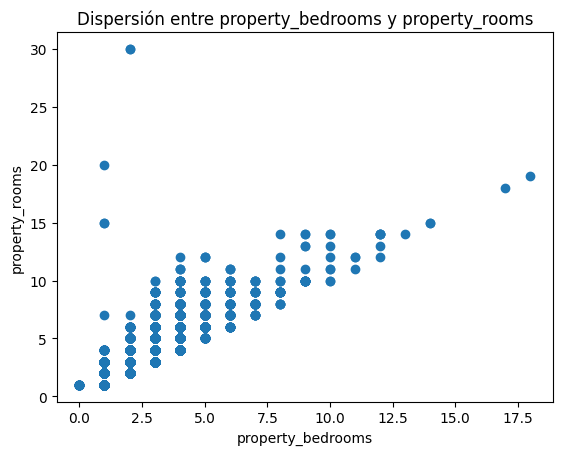

In [358]:
mostrar_dispersion("property_bedrooms","property_rooms")

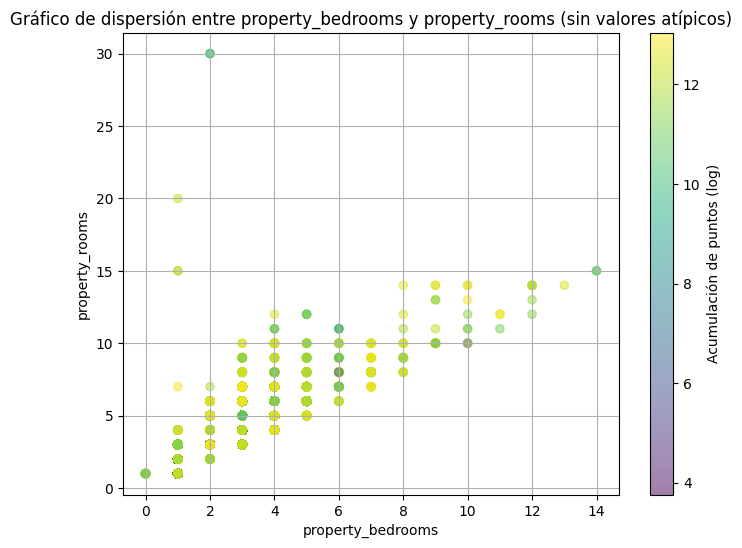

In [359]:
mediana = df["property_bedrooms"].median()

limite_superior = mediana * 7

df = df[df["property_bedrooms"] <= limite_superior]

plt.figure(figsize=(8, 6))
plt.scatter(df["property_bedrooms"], df["property_rooms"], c=np.log(df.index + 1), cmap="viridis", alpha=0.5)
plt.title("Gráfico de dispersión entre property_bedrooms y property_rooms (sin valores atípicos)")
plt.xlabel("property_bedrooms")
plt.ylabel("property_rooms")
plt.colorbar(label="Acumulación de puntos (log)")
plt.grid(True)
plt.show()

#### Precios

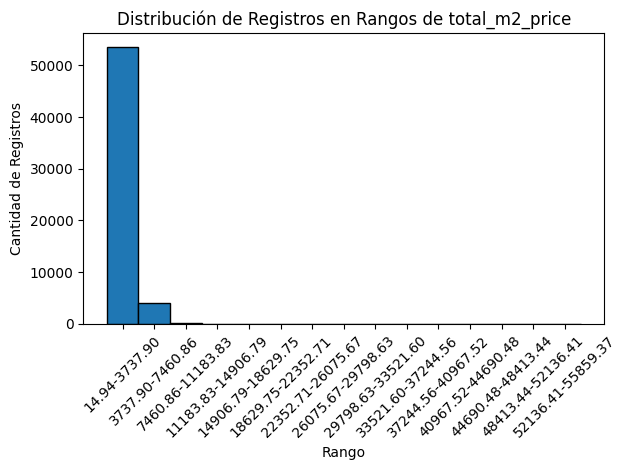

In [360]:
num_bins = 15
bin_width = (df["total_m2_price"].max() - df["total_m2_price"].min()) / num_bins
bins = [df["total_m2_price"].min() + i * bin_width for i in range(num_bins + 1)]

hist, bins = np.histogram(df["total_m2_price"], bins=bins)

plt.bar(range(len(hist)), hist, width=1, edgecolor="black")

plt.xlabel("Rango")
plt.ylabel("Cantidad de Registros")
plt.title("Distribución de Registros en Rangos de total_m2_price")

plt.xticks(range(len(hist)), [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(hist))], rotation=45)

plt.tight_layout()
plt.show()

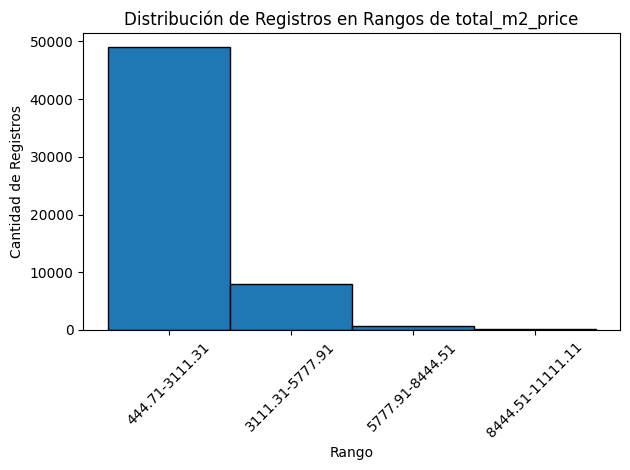

In [361]:
# Vemos que hay numeros irrisorios. Tomo la media y elimino en un rango de 5 veces menor y 5 veces mayor
mediana_total_m2_price = df["total_m2_price"].median()

limite_inferior = mediana_total_m2_price / 5
limite_superior = mediana_total_m2_price * 5

df = nuevo_df = df[(df["total_m2_price"] >= limite_inferior) & (df["total_m2_price"] <= limite_superior)]

num_bins = 4
bin_width = (df["total_m2_price"].max() - df["total_m2_price"].min()) / num_bins
bins = [df["total_m2_price"].min() + i * bin_width for i in range(num_bins + 1)]

hist, bins = np.histogram(df["total_m2_price"], bins=bins)

plt.bar(range(len(hist)), hist, width=1, edgecolor="black")

plt.xlabel("Rango")
plt.ylabel("Cantidad de Registros")
plt.title("Distribución de Registros en Rangos de total_m2_price")

plt.xticks(range(len(hist)), [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(hist))], rotation=45)

plt.tight_layout()
plt.show()

In [362]:
# Despues de revisar todos estos valores atípicos vemos que borramos aprox 5k filas de las 75399 con las que empezamos. No me parece mal
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57814 entries, 115426 to 134904
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   57814 non-null  float64
 1   longitud                  57814 non-null  float64
 2   place_l2                  57814 non-null  object 
 3   place_l3                  57814 non-null  object 
 4   property_type             57814 non-null  object 
 5   property_rooms            57814 non-null  float64
 6   property_bedrooms         57814 non-null  float64
 7   property_surface_total    57814 non-null  float64
 8   property_surface_covered  57814 non-null  float64
 9   property_price            57814 non-null  float64
 10  property_title            57814 non-null  object 
 11  total_m2_price            57814 non-null  float64
 12  covered_m2_price          57814 non-null  float64
dtypes: float64(9), object(4)
memory usage: 6.2+ MB


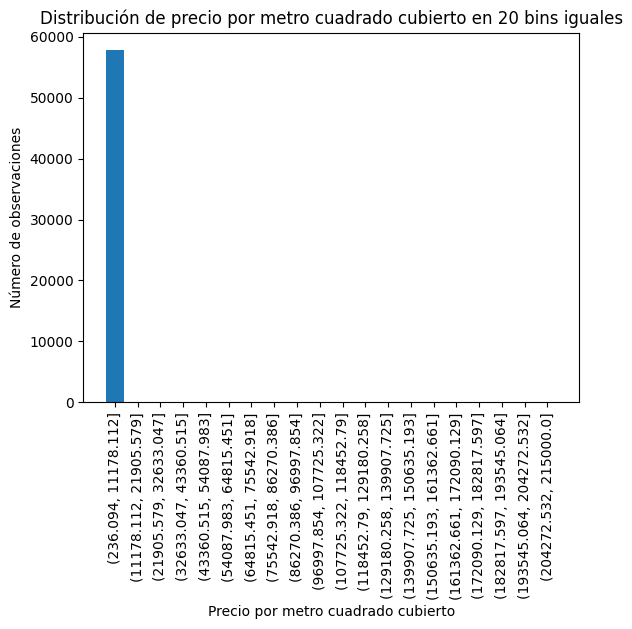

In [363]:
# Analizamos la relación entre los m2 cubiertos y la cantidad de ambientes

bins = pd.cut(df["covered_m2_price"], bins=20)

price_counts = bins.value_counts().sort_index()

plt.bar(range(len(price_counts)), price_counts, tick_label=price_counts.index.astype(str))
plt.title("Distribución de precio por metro cuadrado cubierto en 20 bins iguales")
plt.xlabel("Precio por metro cuadrado cubierto")
plt.ylabel("Número de observaciones")
plt.xticks(rotation=90)
plt.show()

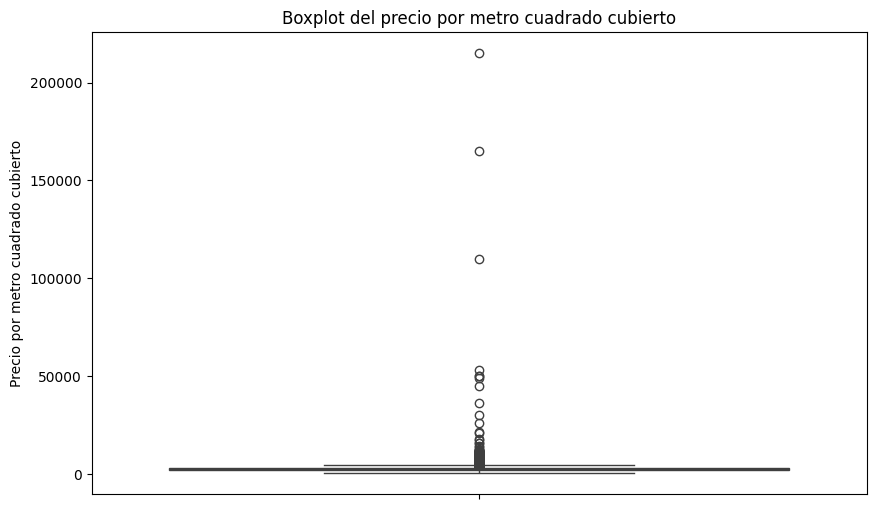

In [364]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="covered_m2_price")
plt.title("Boxplot del precio por metro cuadrado cubierto")
plt.ylabel("Precio por metro cuadrado cubierto")
plt.show()

In [365]:
q1 = df["covered_m2_price"].quantile(0.25)
q3 = df["covered_m2_price"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_filtered = df[(df["covered_m2_price"] >= lower_bound) & (df["covered_m2_price"] <= upper_bound)]

percentage_outliers = 100 - len(df_filtered) / len(df) * 100
print("Porcentaje de outliers eliminados: ", percentage_outliers)

df = df_filtered.copy()

Porcentaje de outliers eliminados:  4.765281765662294


### Conclusión imputaciones

#### Cantidad de registros filtrados

(55059, 13)
(75399, 20)


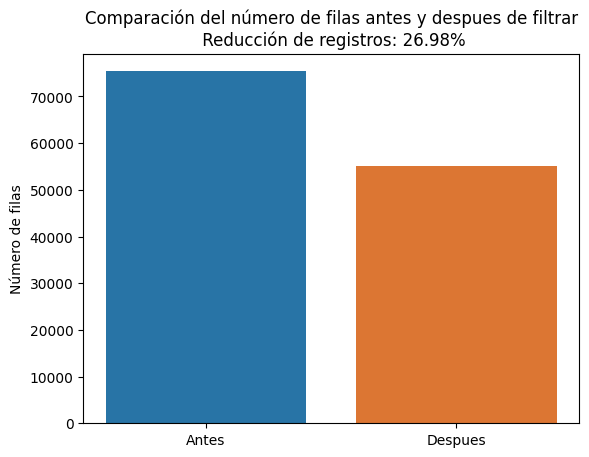

In [366]:
print(df.shape)
print(_df.shape)

# Contar el número de filas en cada DataFrame
num_filas_df = len(df)
num_filas__df = len(_df)

# Calcular el porcentaje de diferencia
porcentaje_diferencia = (100-(num_filas_df * 100 / num_filas__df))

# Graficar
plt.bar(['Antes', 'Despues'], [num_filas__df, num_filas_df], color=[AZUL, NARANJA])
plt.ylabel('Número de filas')
plt.title('Comparación del número de filas antes y despues de filtrar\n Reducción de registros: {:.2f}%'.format(porcentaje_diferencia))
plt.show()

#### Impacto de la imputación y tratamiento de valores atípicos en los gráficos

Despues de realizar las imputaciones esperamos obtener gráficos visualmente más interpretables. Los valores atípicos causan una gran dificultad a la hora de interpretar lo visualizado.
De notar una mejoría, volvemos a visualizar las distribuciones y correlaciones evaluadas en los puntos 1.B y 1.C

##### Relación entre coordenadas y precio

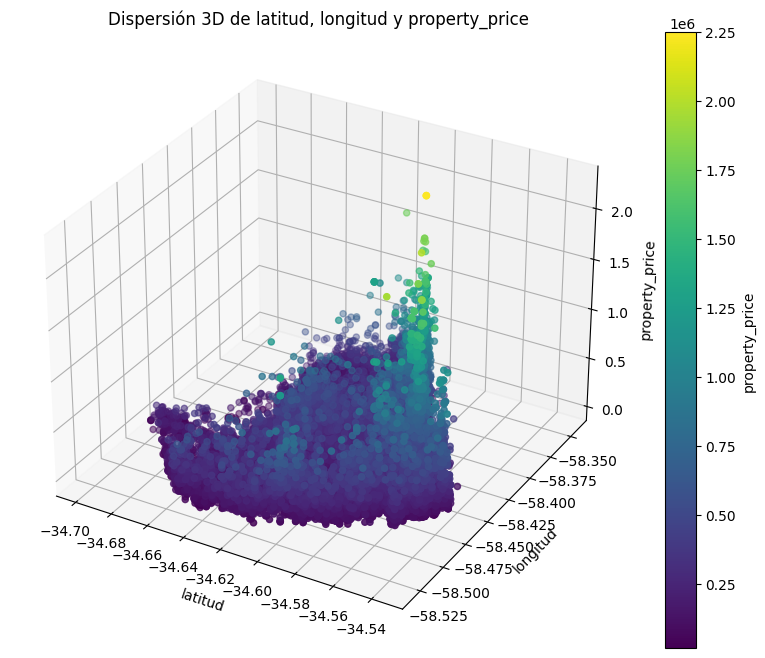

In [367]:
mostrar_dispersion_3d("latitud","longitud","property_price")

Vemos a que barrios corresponden los picos obtenidos en el gráfico

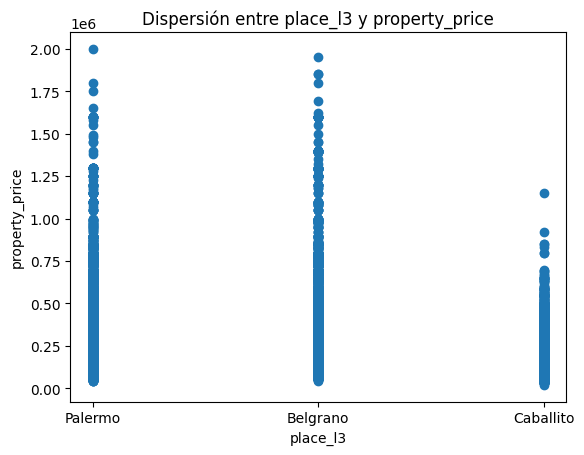

In [368]:
top_3_barrios = df["place_l3"].value_counts().nlargest(3).index.tolist()

df_backup = df

df = df[df['place_l3'].isin(top_3_barrios)]

mostrar_dispersion("place_l3","property_price")


df = df_backup

##### Muestras por tipo de propiedad

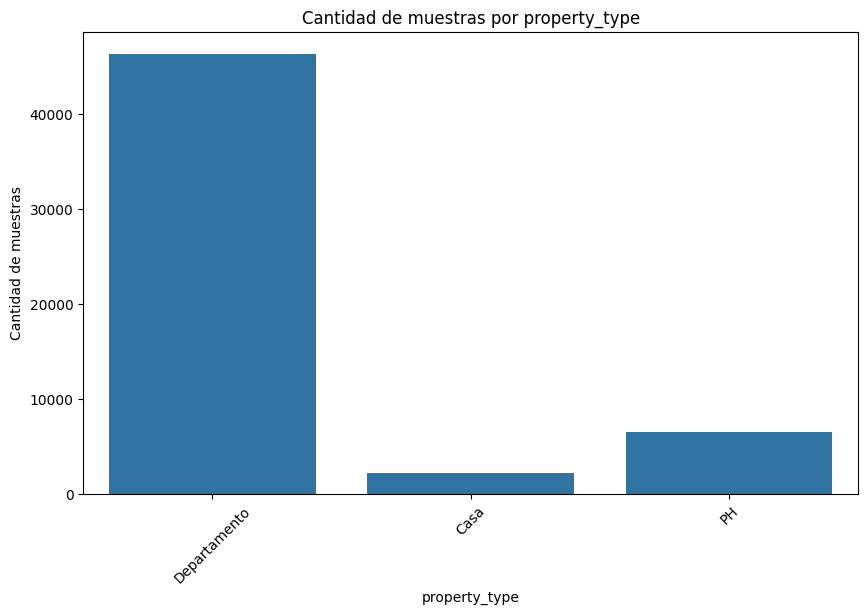

In [369]:
mostrar_distros_cuantitativas("property_type")

## E. Visualización de distribuciones y correlaciones post imputaciones

Viendo que tras el análisis y retoque de los valores atípicos los gráficos brindan más información, repetimos los gráficos de correlación y distribuciones previos para visualizar el impacto del tratamiento hecho.

En la conclusión de la sección se elabora un análisis.

### Correlaciones

#### Heatmap

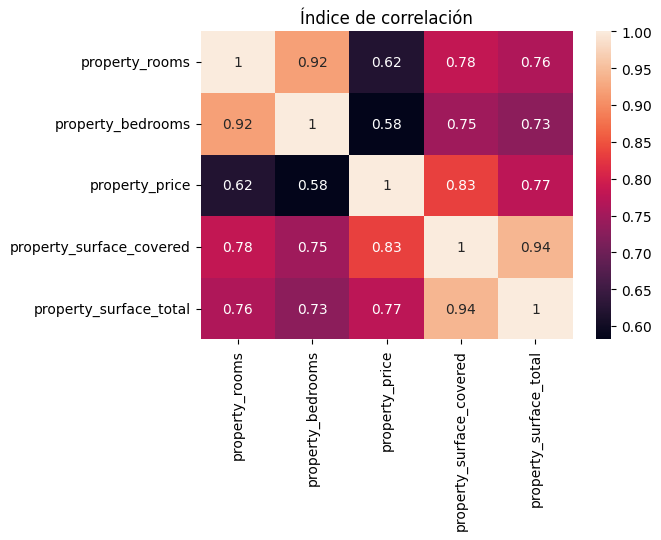

In [370]:
graficar_heatmap(["property_rooms", "property_bedrooms", "property_price", "property_surface_covered", "property_surface_total"])

#### Relación entre cantidad de habitaciones y de ambientes

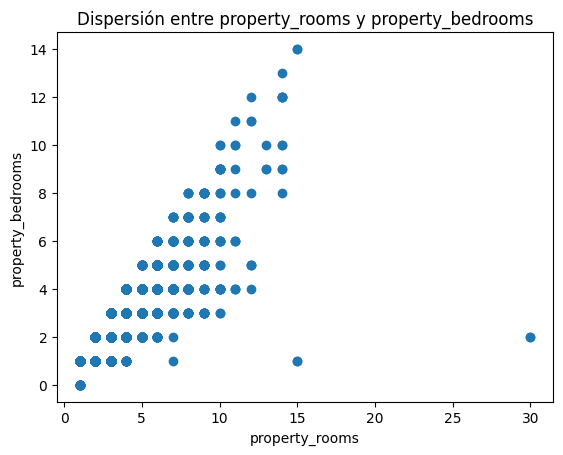

In [371]:
mostrar_dispersion("property_rooms","property_bedrooms")

#### Relacion entre superficies

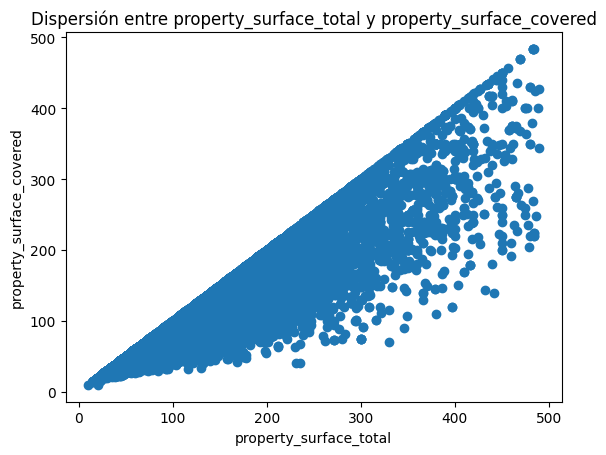

In [372]:
mostrar_dispersion("property_surface_total","property_surface_covered")

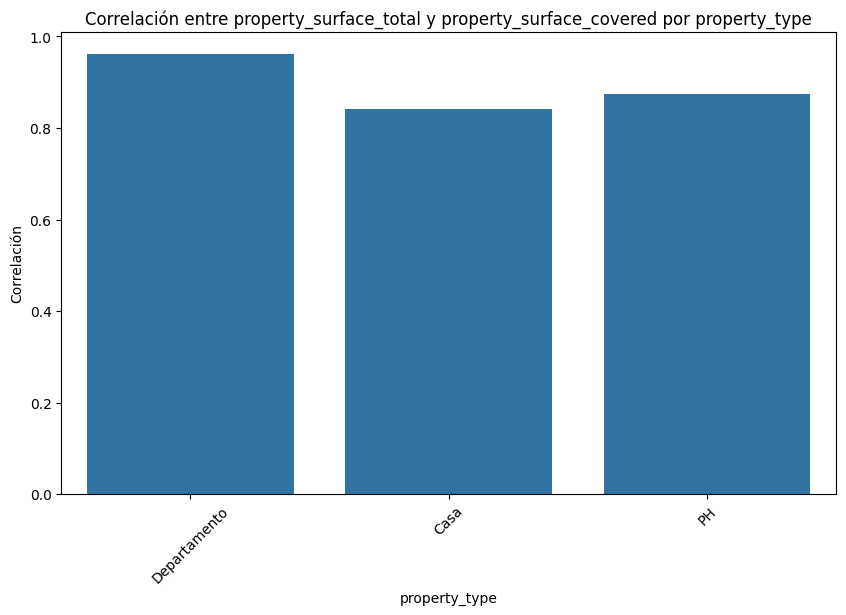

In [373]:
grafico_correlacion_por_categoría("property_surface_total","property_surface_covered","property_type")

In [374]:
df_departamentos = df[df["property_type"] == "Departamento"]

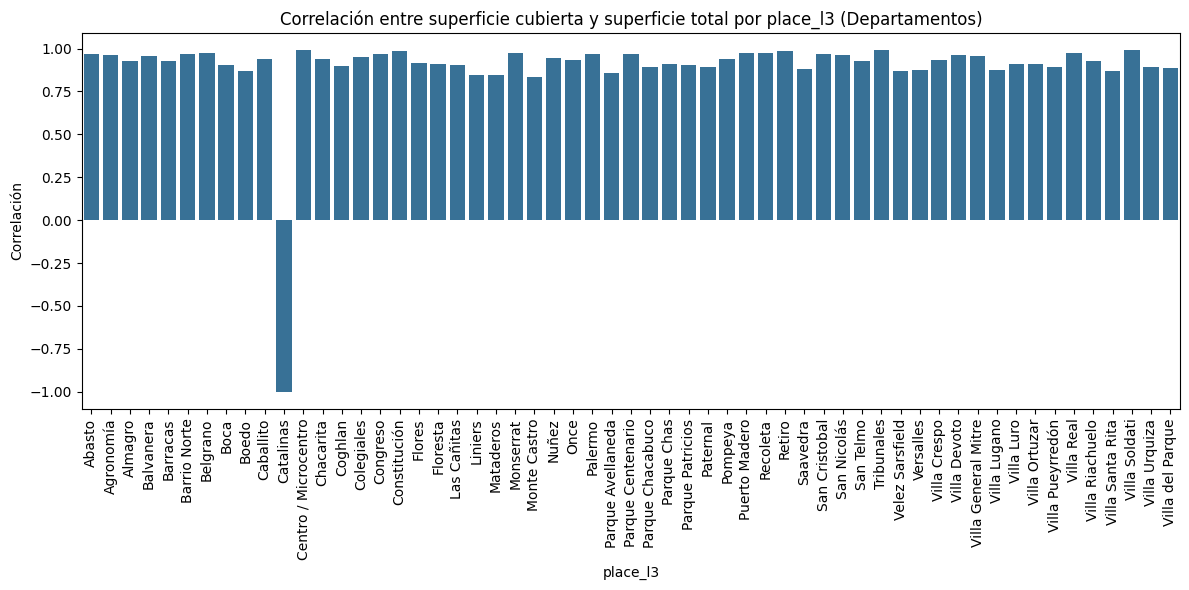

In [375]:
graficar_correlaciones_superficie_por_tipo_de_propiedad()

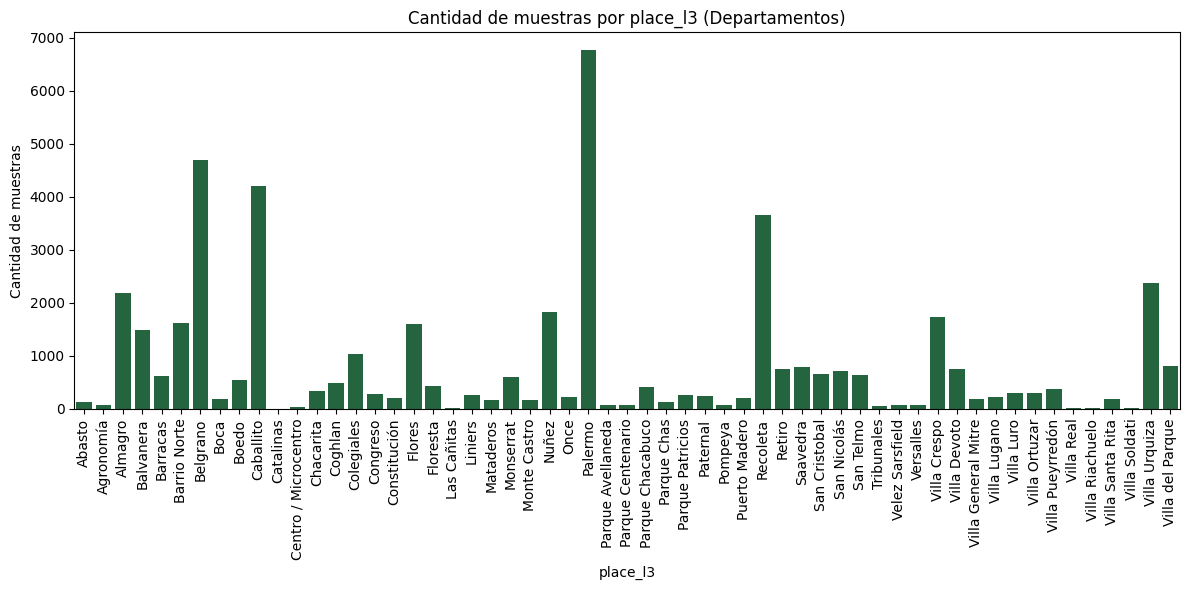

In [376]:
graficar_correlaciones_superficie_por_place_l3()

### Distribuciones


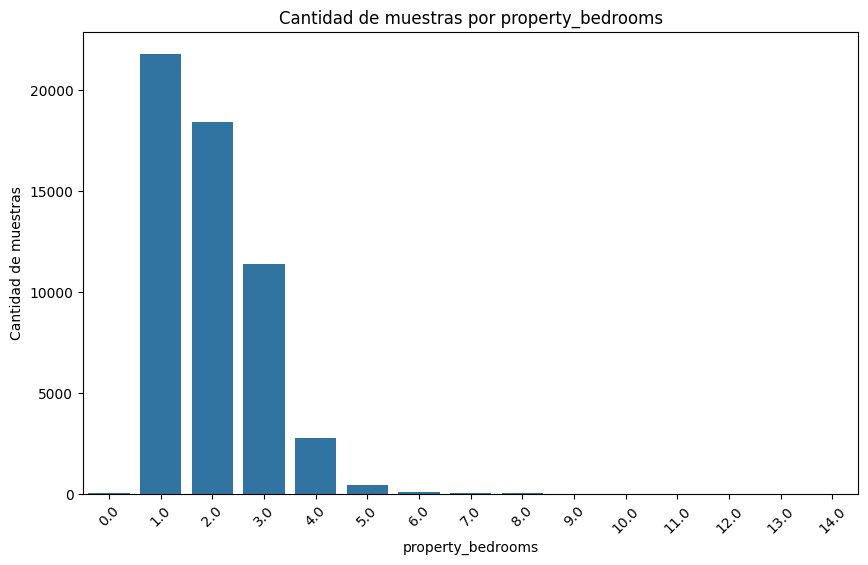

In [377]:
mostrar_distros_cuantitativas("property_bedrooms")

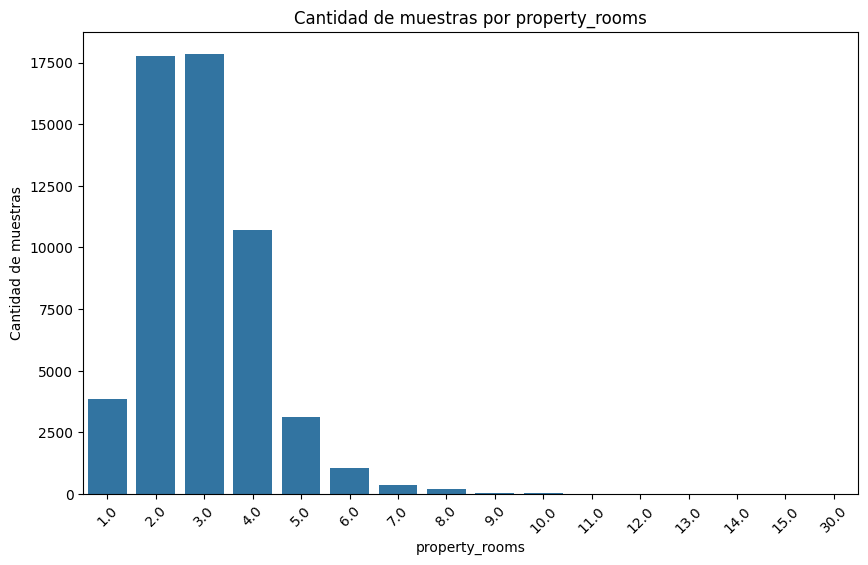

In [378]:
mostrar_distros_cuantitativas("property_rooms")

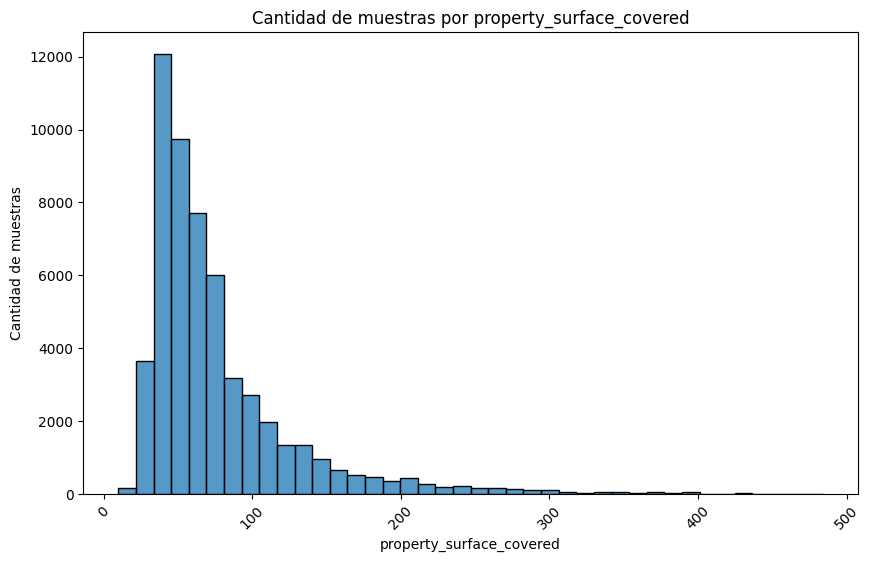

In [379]:
mostrar_distros_cuantitativas_continuas("property_surface_covered")

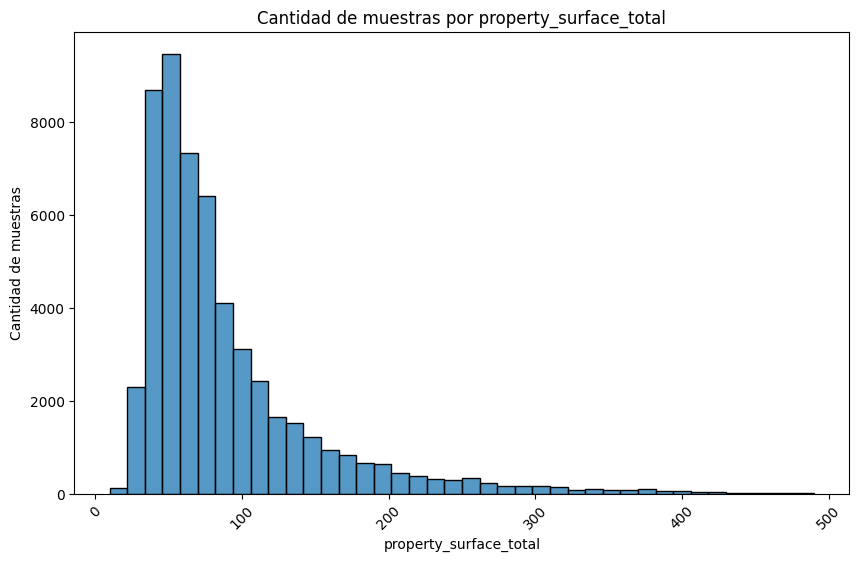

In [380]:
mostrar_distros_cuantitativas_continuas("property_surface_total")

En los graficos de distribuciones cuantitativas continuas apreciamos una gran acumulación. Para poder ver a detalle será necesario revisar los datos que agrandan la escala y generan esos cúmulos.

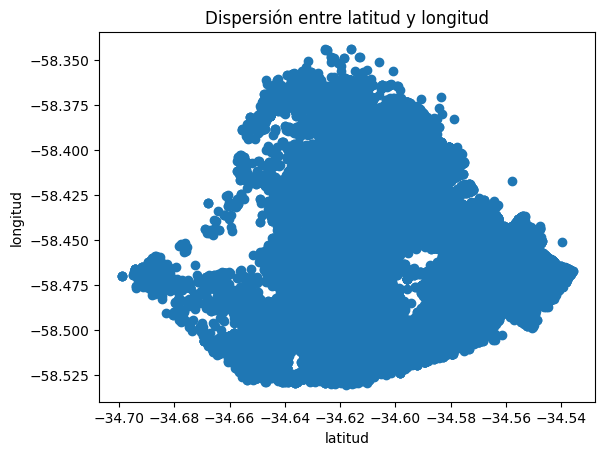

In [381]:
mostrar_dispersion("latitud","longitud")

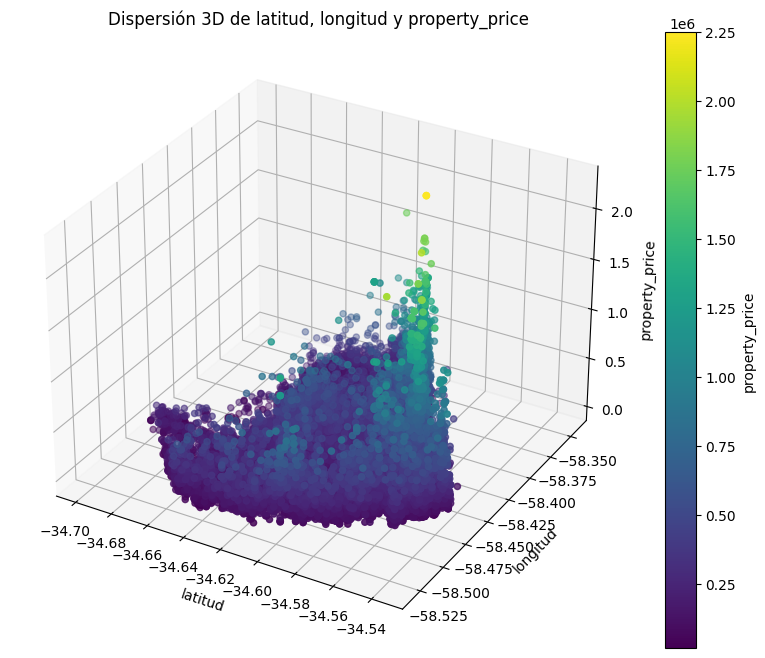

In [382]:
mostrar_dispersion_3d("latitud","longitud","property_price")

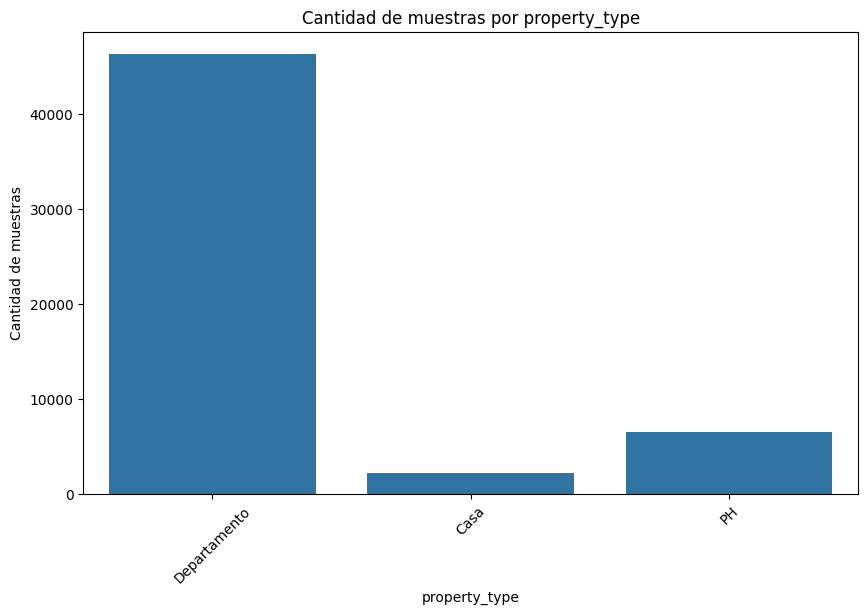

In [383]:
mostrar_distros_cuantitativas("property_type")

### Conclusiones

#### General

La primera impresión al ver los mismos gráficos pero con los datos retocados es positiva. Se nota una clara mejora en la facilidad para la interpretación de los mismos, además de que los valores cobran mucho más sentido.

Sin embargo, estos gráficos tambien delatan detalles omitidos durante la etapa de análisis de valores atípicos, mostrando los puntos a reforzar para poder lograr un mejor modelo.

#### Tratamiento de atípicos

Aún tras los retoques hechos persisten valores por fuera de lo esperable, como lo es el caso de las propiedades con mucha mayor cantidad de ambientes que de habitaciones.

Tambien se percibe un valor extraño en la correlación entre los tipos de superficie en departamentos en Catalinas.

## F. Preparación de la siguiente etapa

Antes de buscar agrupar, necesitamos dejar el df unicamente con valores numéricos, asique pasamos a realizar eso.

In [384]:
df = pd.get_dummies(df, columns=["property_type"])

In [385]:
df.drop(columns=["place_l2", "property_title"], inplace=True)
df.rename(columns={"property_type_Casa": "Casa", "property_type_Departamento": "Departamento", "property_type_PH": "PH"}, inplace=True)
df["Casa"] = df["Casa"].astype(int)
df["Departamento"] = df["Departamento"].astype(int)
df["PH"] = df["PH"].astype(int)

In [386]:
top_3_barrios = df["place_l3"].value_counts().nlargest(3).index.tolist()

for value in top_3_barrios:
    df[value] = (df["place_l3"] == value).astype(int)

df["Otro barrio"] = (~(df["place_l3"].isin(top_3_barrios))).astype(int)

df.drop(columns=["place_l3"], inplace=True)

In [387]:
df.head(5)

latitud   longitud  property_rooms  property_bedrooms  \
115426 -34.598103 -58.442806             1.0                1.0   
256212 -34.583233 -58.403942             4.0                3.0   
304754 -34.578438 -58.462492             4.0                3.0   
259655 -34.597612 -58.419316             2.0                1.0   
172350 -34.612999 -58.424641             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
115426                    30.0                      27.0         79000.0   
256212                   200.0                     200.0        790000.0   
304754                    79.0                      79.0        178900.0   
259655                    53.0                      49.0        143900.0   
172350                    73.0                      63.0        110000.0   

        total_m2_price  covered_m2_price  Casa  Departamento  PH  Palermo  \
115426     2633.333333       2925.925926     0             1   0        0   
256212     3950.000000       3950.000000     0             1   0        1   
304754     2264.556962       2264.556962     0             1   0        0   
259655     2715.094340       2936.734694     0             1   0        1   
172350     1506.849315       1746.031746     0             1   0        0   

        Belgrano  Caballito  Otro barrio  
115426         0          0            1  
256212         0          0            0  
304754         0          0            1  
259655         0          0            0  
172350         0          0            1

Buscamos el SSE (Error Sum of Squares) con el atributo inertia_ de una instancia de KMeans.

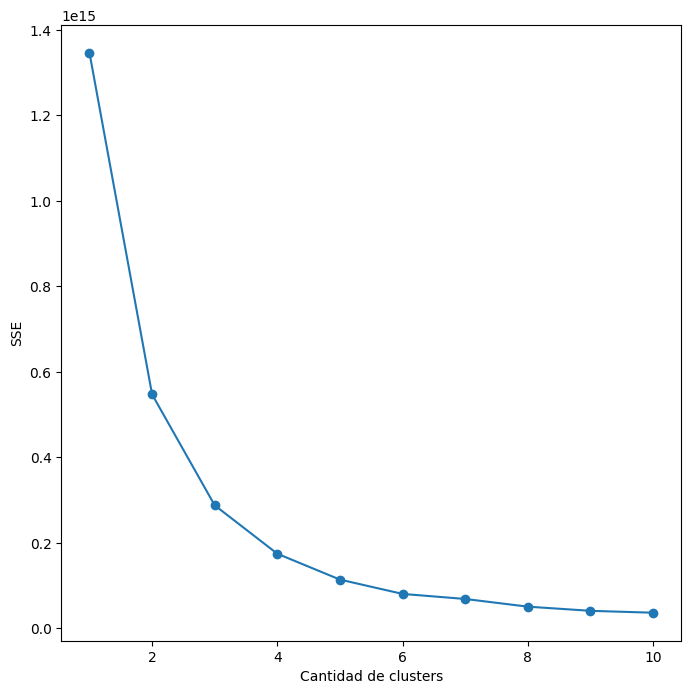

In [388]:
sse = []
k_values = list(range(1, 11))

for k in k_values:
    km = KMeans(n_clusters = k)
    km.fit(df)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(k_values, sse, "-o")
plt.xlabel("Cantidad de clusters")
plt.ylabel("SSE")
plt.show()

Notamos que el error del SSE es demasiado alto, en principio no sabemos a que se debe, pero es sospechoso ...

Vemos que el error se empieza a "planchar" cuando la cantidad clusters es >= 2.

In [389]:
for k in range(2, 5):
    clusterer = KMeans(n_clusters=k, random_state=0)
    preds = clusterer.fit_predict(df)

    score = silhouette_score(df, preds)
    print(f"Para {k} grupos el silhouette score es {score}")

Para 2 grupos el silhouette score es 0.7485739011616015
Para 3 grupos el silhouette score es 0.6649121589775739
Para 4 grupos el silhouette score es 0.6018179599147565


# 2. Agrupamiento

### Análisis separando el df en dos grupos

In [390]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df)
grupos = kmeans.predict(df)

In [391]:
grupo1 = df[grupos == 0]
grupo2 = df[grupos == 1]

In [392]:
grupo1.shape, grupo2.shape

((49627, 16), (5432, 16))

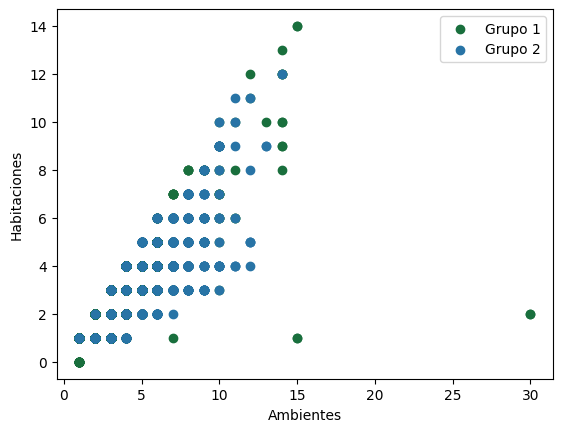

In [393]:
plt.scatter(grupo1["property_rooms"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Ambientes")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

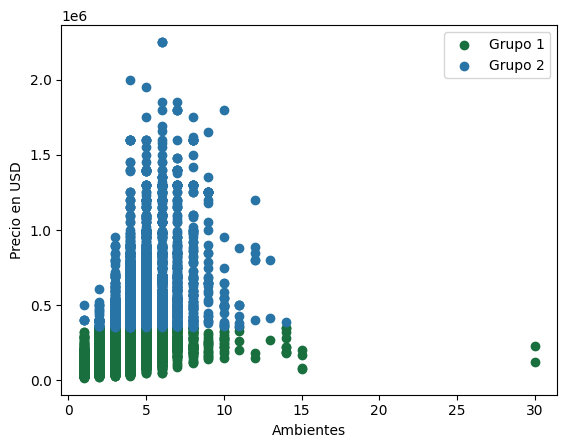

In [394]:
plt.scatter(grupo1["property_rooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Ambientes")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

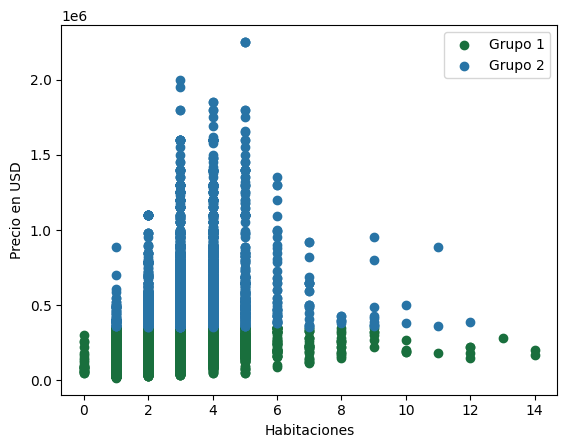

In [395]:
plt.scatter(grupo1["property_bedrooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_bedrooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Habitaciones")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

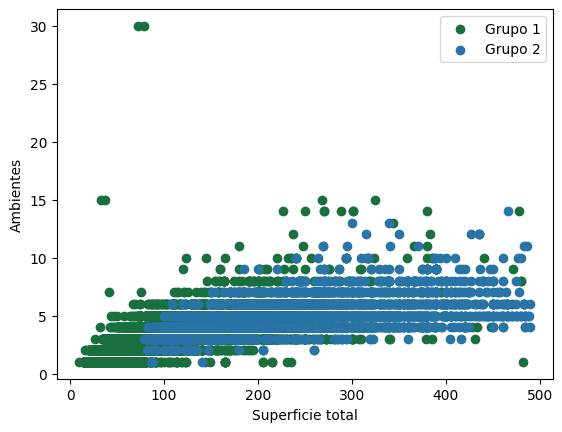

In [396]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_rooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_rooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

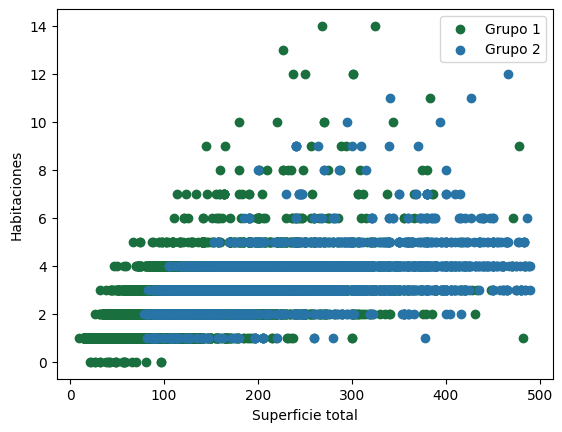

In [397]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

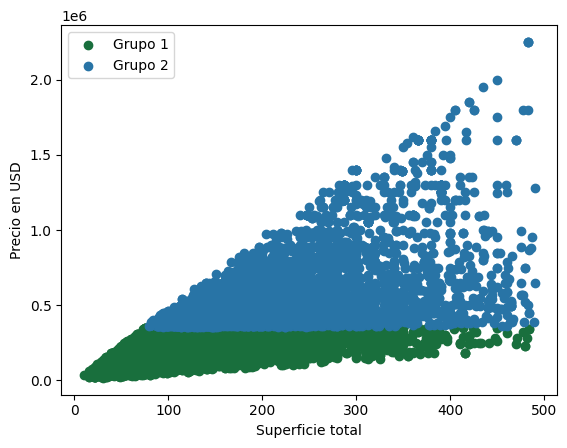

In [398]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

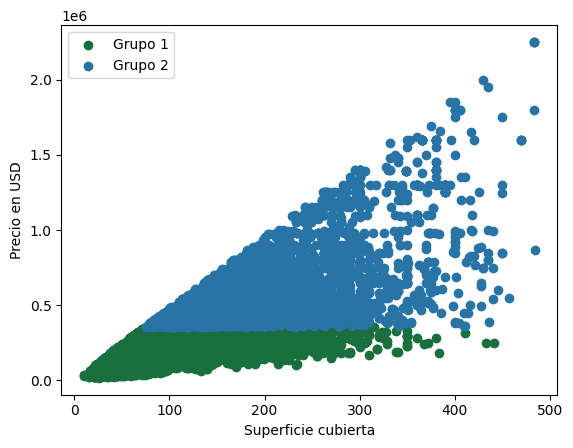

In [399]:
plt.scatter(grupo1["property_surface_covered"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_covered"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie cubierta")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

Por estos graficos podemos ver que la tendencia indica que los grupos están diferenciados de acuerdo al valor de la propiedad en USD.

In [400]:
barrios_caba = gpd.read_file("barrios.geojson")
p = gpd.GeoSeries(barrios_caba.geometry)

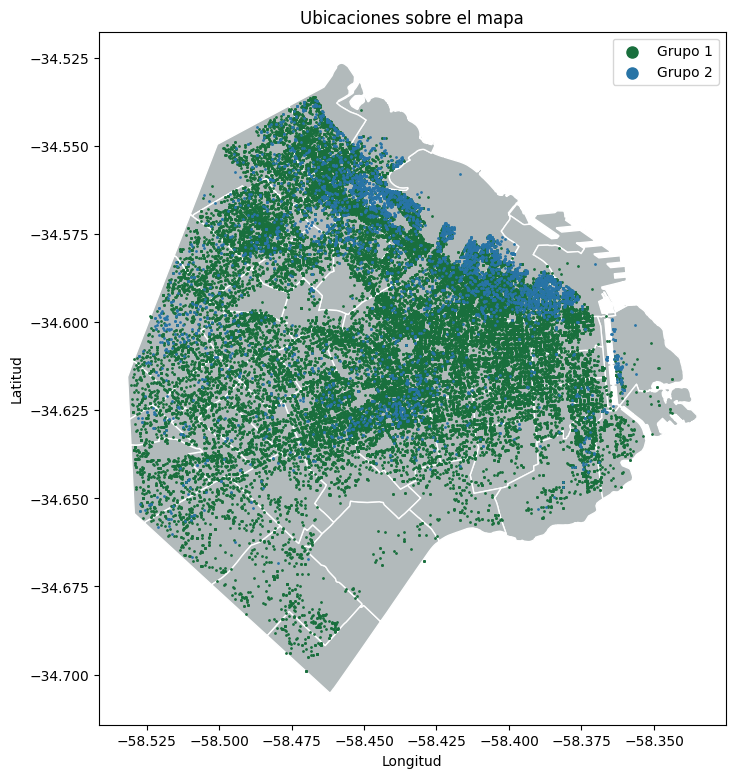

In [401]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

plt.scatter(grupo1["longitud"], grupo1["latitud"], s = 1, c = COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["longitud"], grupo2["latitud"], s = 1, c = COLORES[1], label = "Grupo 2")
plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale = 8)
plt.show()

### Análisis separando el df en tres grupos

In [402]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df)
grupos = kmeans.predict(df)

In [403]:
grupo1 = df[grupos == 0]
grupo2 = df[grupos == 1]
grupo3 = df[grupos == 2]

In [404]:
grupo1.shape, grupo2.shape, grupo3.shape

((42973, 16), (1372, 16), (10714, 16))

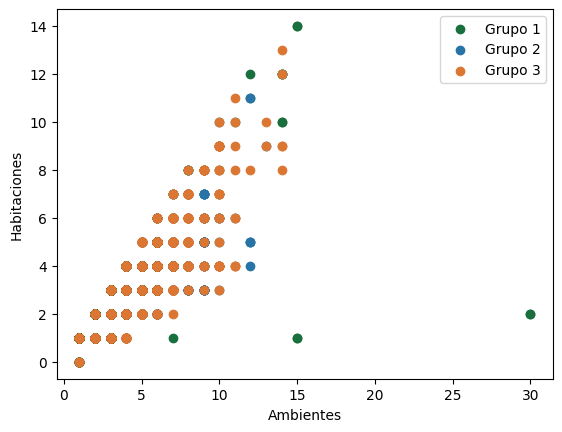

In [405]:
plt.scatter(grupo1["property_rooms"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_rooms"], grupo3["property_bedrooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Ambientes")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

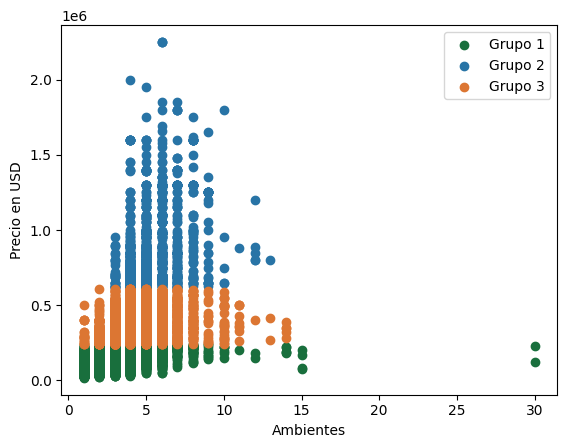

In [406]:
plt.scatter(grupo1["property_rooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_rooms"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Ambientes")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

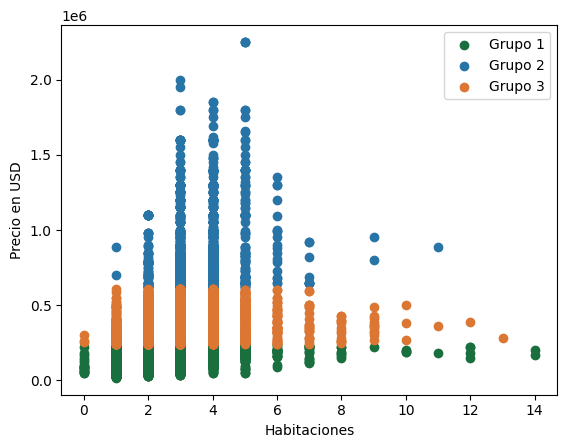

In [407]:
plt.scatter(grupo1["property_bedrooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_bedrooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_bedrooms"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Habitaciones")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

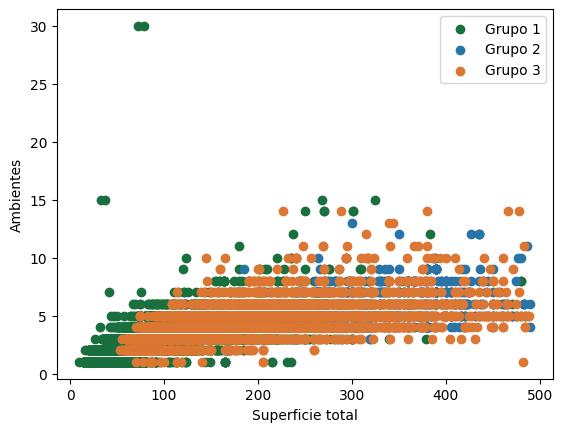

In [408]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_rooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_rooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_rooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

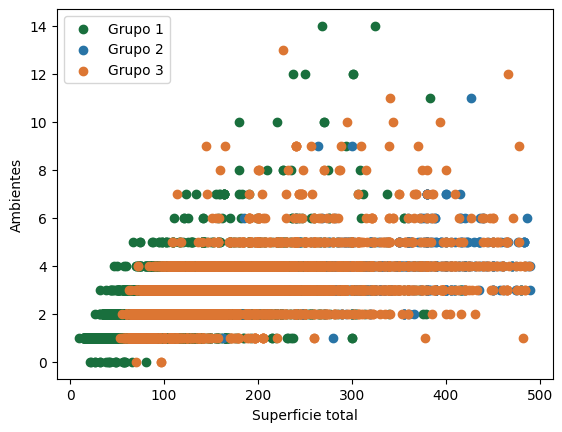

In [409]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_bedrooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

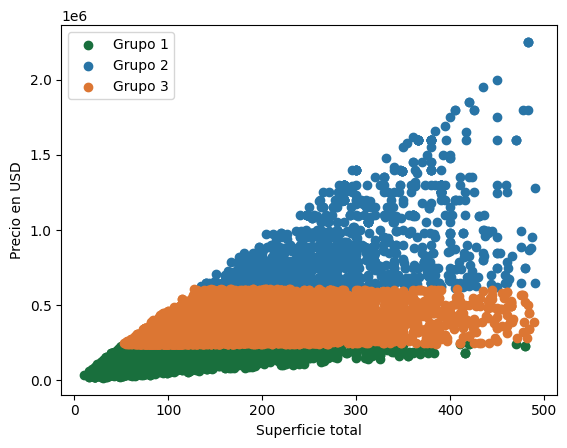

In [410]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

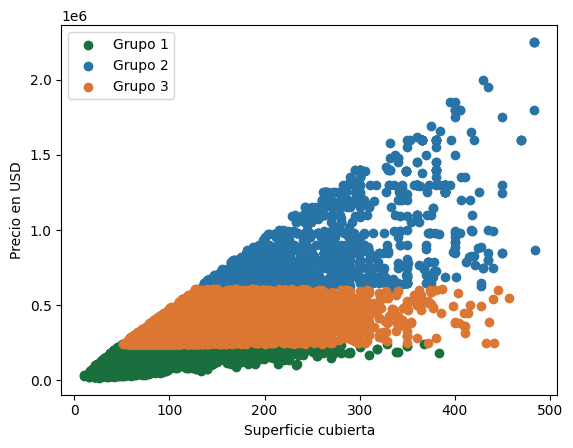

In [411]:
plt.scatter(grupo1["property_surface_covered"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_covered"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_covered"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie cubierta")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

Vemos que nuevamente la tendencia de los clusters es dividirse segun el precio de la propiedad en USD.

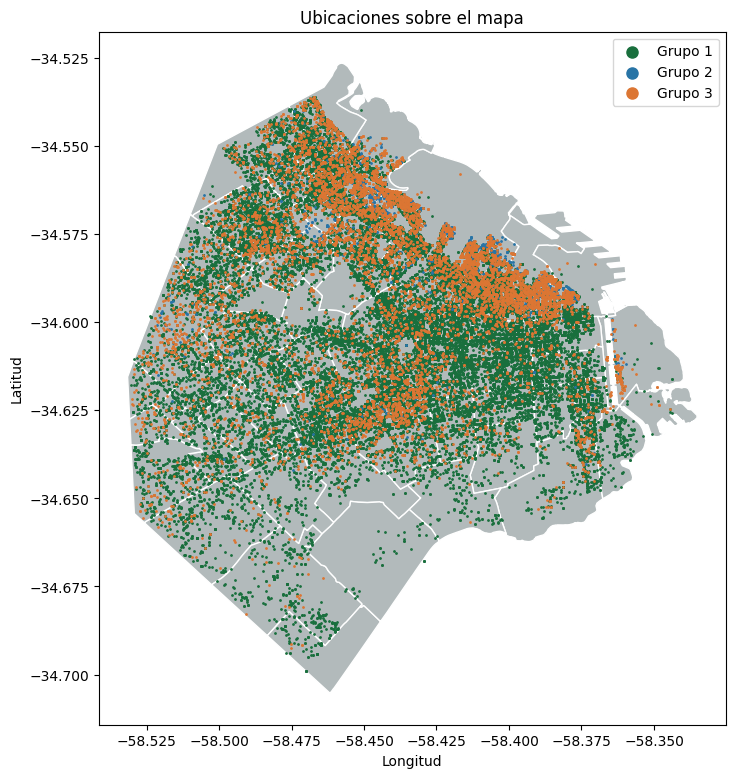

In [412]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

plt.scatter(grupo1["longitud"], grupo1["latitud"], s = 1, c = COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["longitud"], grupo2["latitud"], s = 1, c = COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["longitud"], grupo3["latitud"], s = 1, c = COLORES[2], label = "Grupo 3")
plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale = 8)
plt.show()

Guardamos ambos datasets en csv y comenzamos en otra notebook la etapa 2.

In [413]:
df.to_csv(PATH_DF_TRAIN)
df_test.to_csv(PATH_DF)

In [414]:
df_test.head(3)

id  start_date    end_date  created_on  \
446819  ajyQoLA/jXLSzjmNPM3NiQ==  2021-01-14  9999-12-31  2021-01-14   
135148  pfyZ2qXD8HhKDGppAPLpTg==  2021-04-06  2021-04-15  2021-04-06   
445316  0Wd/m5GJQ6bdFr2mMiA/jQ==  2021-05-20  2021-06-05  2021-05-20   

          latitud   longitud         place_l2          place_l3 place_l4  \
446819 -34.600813 -58.497620  Capital Federal  Villa del Parque      NaN   
135148 -34.556298 -58.439923  Capital Federal          Belgrano      NaN   
445316 -34.612908 -58.386174  Capital Federal          Congreso      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
446819      NaN       NaN     Venta  Departamento             1.0   
135148      NaN       NaN     Venta  Departamento             5.0   
445316      NaN       NaN     Venta  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
446819                NaN                    45.0                      41.0   
135148                3.0                   175.0                     141.0   
445316                NaN                    25.0                       NaN   

        property_price property_currency  \
446819        130000.0               USD   
135148        579000.0               USD   
445316         49000.0               USD   

                                           property_title  
446819  VENTA MONOAMBIENTE DIVISIBLE C/ COCHERA EN VIL...  
135148                            Departamento - Belgrano  
445316                   Venta | Monoambiente | Monserrat